## Data Science Job Salary & Job Role Prediction

<a id="table-of-contents"></a>

### Table of Contents
- [Introduction](#introduction)
- [Import Libraries](#import-libraries)
- [Scrape the Data](#scrape)
- [Data Preprocessing](#clean-scraped-data)
- [Salary Range Distribution per Hiring Company](#salary-range-per-company)
- [Top Hiring Companies per Salary Range](#top-companies-per-salary-range)
- [Salary Classification Prediction](#salary-prediction)
 - [Top 20 Job Titles](#top-job-titles)
 - [Top 20 Job Descriptions](#top-job-descriptions)
 - [Baseline Accuracy](#baseline-accuracy)
 - [Fit, Predict, Evaluate](#fit-models)
 - [Logistic Regression, Naive Bayes, KNN](#lr-nb-knn)
 - [Decision Tree, Random Forest, Extra Trees, Bagging](#dt-ensemble)
 - [Feature Selection - SelectKBest](#selectkbest)
 - [Stochastic Gradient Descent - GridSearchCV](#gridsearch-sgd)
 - [Model Performance Comparison - Chart](#model-performance-comparison-chart)
 - [Model Performance Comparison - Conclusion](#model-performance-comparison-conclusion)
 - [Fit Final Model on Test Set](#fit-model-test-set)
 - [Fit Final Model on Test Set - Conclusion](#fit-model-test-set-conclusion)
 - [Minimize Wrong Predictions of High Salary](#minimize-wrong-predictions)
 - [Minimize Wrong Predictions of High Salary - Conclusion](#minimize-wrong-predictions-conclusion)
- [Job Role Prediction](#job-role-prediction)
 - [Key Feature Identification](#feature-identification)
 - [Job Role Prediction - Conclusion](#job-role-prediction-conclusion)

<a id="introduction"></a>

### Introduction
[<- Back to Table of Contents](#table-of-contents)

When on the hunt for a data science job, your platform of choice could include at least one of the following:
- Seek
- LinkedIn
- Your own professional network
- Family & friends referrals

Out of these four options, it would be easy to consider Seek as your default choice and the main reason for that is their sheer volume of job postings that is almost unmatched by any of the other alternatives.

This however comes at a significant cost on the part of the job seeker, as having to sift through a vast array of job postings can easily become overwhelming.

The Job Salary & Job Role Prediction system is designed to address this problem, specifically through the following main objectives:

Objective 1: Salary Prediction: to predict whether a given data role is a low-salary role or a high-salary role.

Objective 2: Job Role Prediction: to predict whether a job posting is a data scientist, data engineer, or a data analyst role. 

The following are supporting objectives that enhance the system's functionality and complement the abovementioned main objectives:

Objective 3: Adjusted-Threshold Prediction: to tweak the salary predictions to minimize false positives.

Objective 4: Feature Identification: to identify the important features within a job posting that help identify the type of data role. 

The dataset was obtained by scraping 13300 job postings from the Seek (seek.com.au) website. These are 'data' jobs located in major cities in Australia.

Models evaluated for prediction include the following:
- Logistic Regression
- Naive Bayes
- KNN
- Decision Tree
- Random Forest
- Extra Trees
- Bagging
- Support Vector Machines
- Stochastic Gradient Descent

<a id="import-libraries"></a>

### Import libraries
[<-](#table-of-contents)

In [3]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
import pickle
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression, \
LogisticRegressionCV, LassoCV, SGDRegressor, SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor, \
RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV, SelectKBest, f_classif, mutual_info_classif, chi2
from sklearn.metrics import mean_squared_error, roc_curve, auc, classification_report, precision_score, recall_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

%matplotlib inline
from time import sleep
from scrapy.selector import Selector
from selenium.webdriver.common.keys import Keys
import requests

%matplotlib inline
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

<a id="scrape"></a>

### Scrape the Data
[<-](#table-of-contents)

The data is scraped from the Seek website, and retrieved through the following search criteria:
- URL: seek.com.au
- Search term: data
- Classification: Any
- Where: All Australia
- Type: Full time, Part time, Contract
- Salary range(K): 0-50k,50-60,60-70,100-120,120-150,150-200,200-999k


In [8]:
# get job url's and store in a list
def get_job_urls(html):
    
    search_results = Selector(text=html).xpath('//a[contains(@class,"_1EkZJQ7")]/@href').extract()
    
    search_results = ['https://www.seek.com.au' + result for result in search_results]
    return search_results

In [9]:
# extract the job details
def get_job_details_per_url(html, salary_range):
        
    # job title
    try:
        job_title=Selector(text=html).xpath('//span[contains(@class,"_3FrNV7v")]/span/h1/text()').extract()[0]
    except:
        job_title=np.NaN

    # company
    try:
        company=Selector(text=html).xpath('//span[@data-automation="advertiser-name"]/span/text()').extract()[0]
    except:
        company=np.NaN

    # description
    try:
        job_description=Selector(text=html).xpath('//div[contains(@data-automation,"jobDescription")]/span/div/div[contains(@class,"_17ZYgCC")]').extract()[0]
    except:
        job_description=np.NaN

    # date_posted    
    try:
        date_posted=Selector(text=html).xpath('//dd[contains(@data-automation,"job-detail-date")]/*/span/text()').extract()[0]
    except:
        date_posted=np.NaN
        
    # location 1    
    try:
        location_1=Selector(text=html).xpath('//dl/dd/span/span/strong[contains(@class,"lwHBT6d")]/text()').extract()[0]
    except:
        location_1=np.NaN
        
    # location 2  
    try:
        location_2=Selector(text=html).xpath('//dl/dd/span/span/span[contains(@class,"_2yTNGy2")]/text()').extract()[0]
    except:
        location_2=np.NaN
        
    # salary
    try:
        salary=Selector(text=html).xpath('//div/dd/span[contains(@class,"_3FrNV7v _3PZrylH E6m4BZb")]/span[contains(@class, "lwHBT6d")]/text()').extract()[0]
    except:
        salary=np.NaN

    # type
    try:
        job_type=Selector(text=html).xpath('//dd[@data-automation="job-detail-work-type"]/span[contains(@class, "_3FrNV7v _3PZrylH E6m4BZb")]/span[contains(@class, "lwHBT6d")]/text()').extract()[0]
    except:
        job_type=np.NaN
        
    # job category 1
    try:
        job_category_1=Selector(text=html).xpath('//div/dd/span[contains(@class,"_3FrNV7v")]/span/strong[contains(@class,"lwHBT6d")]/text()').extract()[0]
    except:
        job_category_1=np.NaN

    # job category 2
    try:
        job_category_2=Selector(text=html).xpath('//div/dd/span[contains(@class,"_3FrNV7v")]/span/span/text()').extract()[0]
    except:
        job_category_2=np.NaN        
        
    # clean data for job description
    remove_tags=['<p>', '</p>', '<ul>', '</ul>', '<li>', '</li>', '\xa0', '<div>', '</div>', 
                 '<strong>', '</strong>','<div data-automation="mobileTemplate" class="_17ZYgCC">']
    
    try:
        for tag in remove_tags:
            if tag in job_description:
                job_description=job_description.replace(tag,' ')
    except:
        print('cannot perform job_description.replace(tag,.. on : ', job_description)
    
    # append job details to list
    job_details = [job_title, company, job_description, date_posted, location_1, location_2, salary, job_type, job_category_1, job_category_2, salary_range]
    
    # return the list of parsed search results
    return job_details


In [ ]:
# initialize lists
all_salary_range_urls=[]
all_salary_range_labels=[]
job_url_list = []
column_list = ['title', 'company', 'description', 'date_posted', 'location_1', 'location_2', 'salary', 'job_type', 'job_category_1', 'job_category_2', 'salary_range']
salary_range = ['0-50000','50000-60000','60000-70000','100000-120000','120000-150000','150000-200000','200000-999999']
salary_range_labels = ['0-50k','50k-60k','60k-70k','100k-120k','120k-150k','150k-200k','200k-999k']

# total # of pages to search for every salary range
total_pages = 200

# set user-agent and initial site
agent = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'}

# iterate through each salary range to get the urls for the pages of search results (based on above criteria) for each 
for range,label in zip(salary_range,salary_range_labels):
    # add the urls of the result pages for this particular salary range
    all_salary_range_urls.append([('https://www.seek.com.au/data-jobs/in-All-Australia?page=' + str(page) + '&salaryrange=' + range + '&salarytype=annual&worktype=242%2C243%2C244') for page in np.arange(1,int(total_pages)+1)])
    # add the label for the salary range that these result pages belong to 
    all_salary_range_labels.append(label)

# iterate through salary ranges
for salary_range_page_urls, salary_range_page_label in zip(all_salary_range_urls,all_salary_range_labels):
            
    jobs_df_per_salary_range = pd.DataFrame(columns=column_list)
    job_url_list = []
    monitor_count=0 
    total_count=le n(salary_range_page_urls)
    # iterate through all job urls per jobs page
    for page_url in salary_range_page_urls:
        response = requests.get(page_url, headers=agent)
        sleep(3)
        html=response.text

        # call get_job_urls function and append result to a list
        job_url_list = job_url_list + get_job_urls(html)

        monitor_count += 1
        #print(str(monitor_count), ' of ', str(total_count), " pages of url's for range ", salary_range_page_label, " retrieved...")

    monitor_count=0    
    total_count=len(job_url_list)
    # iterate through the jobs and scrape details for each
    for job_url in job_url_list:

        response = requests.get(job_url, headers=agent)
        sleep(3)
        html=response.text

        # get job details function, and save result to a dataframe
        jobs_df_per_salary_range.loc[jobs_df_per_salary_range.shape[0]] = get_job_details_per_url(html, salary_range_page_label)        

        monitor_count += 1
        #print(str(monitor_count), ' of ', str(total_count), " (range ", salary_range_page_label, ") jobs saved to df..")

        if (monitor_count == 200):
            jobs_df_per_salary_range.to_csv(salary_range_page_label + ' - ' + str(monitor_count) + ' urls.csv');

    # save to per_salary_range scraped data to csv for monitoring
    jobs_df_per_salary_range.to_csv(salary_range_page_label + '.csv');

### Export scraped jobs to csv

In [ ]:
# save per-salary-range csv's to jobs_df

# initialize empty dataframe
column_list = ['title', 'company', 'description', 'date_posted', 'location_1', 'location_2', 'salary', 'job_type', 'job_category_1', 'job_category_2', 'salary_range']
jobs_df = pd.DataFrame(columns=column_list)

all_salary_range_labels = ['0-50k','50k-60k','60k-70k','100k-120k','120k-150k','150k-200k','200k-999k']

# iterate through salary ranges
for salary_range_page_label in all_salary_range_labels:
    # import csv for each salary range
    salary_range_df = pd.read_csv(salary_range_page_label + '.csv')
    # append per salary range dataframe to main jobs dataframe
    jobs_df = pd.concat([jobs_df,salary_range_df],ignore_index=True)

# save all jobs to csv for backup
jobs_df.to_csv('data jobs - stage 1 - after scraping.csv');

### Import data jobs.csv

In [16]:
# # This cell is to be executed ONLY when needing to bypass the scraping process above.
# # In this cell the .csv file containing all the scraped jobs will instead be loaded
# # to a dataframe
jobs_df = pd.read_csv('data jobs - stage 1 - after scraping.csv')

<a id="clean-scraped-data"></a>

### Data preprocessing
[<-](#table-of-contents)

In [17]:
# drop the 2 sub-index columns imported from data jobs.csv
jobs_df.drop(jobs_df.columns[:2],axis=1,inplace=True)

In [18]:
# check for NaN's
jobs_df.isnull().sum()

company            7118
date_posted         114
description         114
job_category_1      114
job_category_2      114
job_type            114
location_1          114
location_2         6501
salary            15024
salary_range          0
title               114
dtype: int64

In [19]:
# drop rows where relevant columns such as description, job_category, company are set to NaN 
jobs_df.drop(index=jobs_df[jobs_df.description.isnull()].index, inplace=True)

In [20]:
# after dropping rows, check for NaN's
jobs_df.isnull().sum()

company            7004
date_posted           0
description           0
job_category_1        0
job_category_2        0
job_type              0
location_1            0
location_2         6387
salary            14910
salary_range          0
title                 0
dtype: int64

In [21]:
# percentage of NaN values per column
jobs_df.isnull().sum()[jobs_df.isnull().sum()>0].sort_values(ascending=False)/jobs_df.shape[0]

salary        0.680822
company       0.319817
location_2    0.291644
dtype: float64

In [22]:
# duplicate rows
# although duplicated() method yields 1246 duplicates, drilling into the details of the duplicated yields slight differences between the supposed duplicates
# therefore, i will forego the removal of duplicates to keep potentially valuable data
jobs_df.loc[jobs_df.duplicated(),:].sort_values('description').head()

,company,date_posted,description,job_category_1,job_category_2,job_type,location_1,location_2,salary,salary_range,title
2270,NaN,5 Oct 2018,\r\r\r\nThe successful candidate you will be ...,Administration & Office Support,Administrative Assistants,Contract/Temp,Gladstone & Central QLD,NaN,NaN,0-50k,Admin Support Officer - EMERALD
17595,Talentpath,12 Oct 2018,\t Contract role till approx Jan 2019 \t ...,"Mining, Resources & Energy",Other,Contract/Temp,Brisbane,CBD & Inner Suburbs,Attractive Contract Day Rates,120k-150k,Category Specialist
16766,Charterhouse,15 Oct 2018,\t Inner-West Sydney; \t 12-month contrac...,Government & Defence,Government - State,Contract/Temp,Sydney,"CBD, Inner West & Eastern Suburbs",NaN,120k-150k,Evaluation Manager | Government Sector
19348,Finite IT Recruitment Solutions,19 Oct 2018,\r\r\n\r\r\n My Large Enterprise Financial...,Information & Communication Technology,Business/Systems Analysts,Contract/Temp,Sydney,"CBD, Inner West & Eastern Suburbs",Fantastic daily rate!,150k-200k,Technical Business Analyst
10442,NaN,22 Oct 2018,\r\r\n \r\r\n \r\r\n \r\r\n \r\r\n \r\r\n ...,Education & Training,Teaching - Secondary,Full Time,Ballarat & Central Highlands,NaN,NaN,60k-70k,Graduate Teacher Program
6541,Queensland Government,23 Oct 2018,\r\r\n \r\r\n \r\r\n Chancellor State Colle...,Education & Training,Other,Full Time,Sunshine Coast,NaN,NaN,50k-60k,Science Operations Officer - Chancellor State ...
8993,NaN,11 Oct 2018,\r\r\n Advanced Analytics &amp; Reporting ...,Banking & Financial Services,Analysis & Reporting,Full Time,Sydney,NaN,NaN,60k-70k,Senior Risk Associate Analytics and Reporting
15674,NaN,23 Oct 2018,\r\r\n Be the expert on audience management...,Marketing & Communications,Direct Marketing & CRM,Full Time,Sydney,"CBD, Inner West & Eastern Suburbs",NaN,120k-150k,Manager Audience and Attribution
1554,NaN,24 Oct 2018,\r\r\n Bendigo location \r\r\n Contract u...,Accounting,Accounts Officers/Clerks,Part Time,"Bendigo, Goldfields & Macedon Ranges",NaN,Bendigo location,0-50k,Assets Support Officer
1553,NaN,24 Oct 2018,\r\r\n Bendigo location \r\r\n Contract u...,Government & Defence,Government - State,Part Time,"Bendigo, Goldfields & Macedon Ranges",NaN,Bendigo location,0-50k,Assets Support Officer


In [23]:
# cast date_posted column to datetime type 
jobs_df.date_posted = pd.to_datetime(jobs_df.date_posted)

In [24]:
jobs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21900 entries, 0 to 22013
Data columns (total 11 columns):
company           14896 non-null object
date_posted       21900 non-null datetime64[ns]
description       21900 non-null object
job_category_1    21900 non-null object
job_category_2    21900 non-null object
job_type          21900 non-null object
location_1        21900 non-null object
location_2        15513 non-null object
salary            6990 non-null object
salary_range      21900 non-null object
title             21900 non-null object
dtypes: datetime64[ns](1), object(10)
memory usage: 2.0+ MB


In [25]:
# shorten company name for Seek
seek = 'Talent – Winner ‘Seek Large Recruitment Agency of the Year’ 3 consecutive years!'
jobs_df.loc[jobs_df.company==seek,'company'] = 'Seek'

In [26]:
jobs_df.salary_range.value_counts()

100k-120k    4027
60k-70k      3933
50k-60k      3925
120k-150k    3653
150k-200k    2667
0-50k        2522
200k-999k    1173
Name: salary_range, dtype: int64

In [27]:
# for 3 fields with NaN's, we can later look into:
# salary: salary prediction based on regex'ed salaries
# company: plots of companies against salary_range, with > 20 job postings
# location_2: plots of location 1 & 2 against salary_range; can also be useful in salary prediction

In [28]:
jobs_df.location_2.value_counts()

CBD, Inner West & Eastern Suburbs      4725
CBD & Inner Suburbs                    4544
Parramatta & Western Suburbs           1041
North Shore & Northern Beaches          834
CBD, Inner & Western Suburbs            648
Eastern Suburbs                         646
Bayside & South Eastern Suburbs         631
Northern Suburbs                        517
Ryde & Macquarie Park                   402
Western Suburbs                         274
South West & M5 Corridor                246
Southern Suburbs & Sutherland Shire     222
North West & Hills District             220
Southern Suburbs & Logan                191
Fremantle & Southern Suburbs            142
Northern Suburbs & Joondalup             95
Western Suburbs & Ipswich                66
Bayside & Eastern Suburbs                53
Rockingham & Kwinana                     16
Name: location_2, dtype: int64

<a id="salary-range-per-company"></a>

### Salary Range Distribution per Hiring Company
[<-](#table-of-contents)

In [29]:
# top companies with counts of job openings
active_hiring_companies = jobs_df.groupby('company').count()['salary_range'].sort_values(ascending=False)
active_hiring_companies = active_hiring_companies[active_hiring_companies > 50]
active_hiring_companies.head(10)

company
Hudson                              250
Robert Walters                      199
Seek                                174
Finite IT Recruitment Solutions     169
Hays Office Support                 169
Bluefin Resources Pty Limited       129
Paxus                               108
Hays Information Technology         105
Xpand Group Pty Ltd                 103
Charterhouse                         99
Greythorn Experis                    97
Hays Accountancy & Finance           91
Viiew Pty Ltd                        89
Ethos BeathChapman                   85
Michael Page                         85
Chandler Macleod Group               83
Robert Half Finance & Accounting     82
M&T Resources                        79
Peoplebank Australia NSW             76
HOBAN Recruitment                    75
FIRCROFT AUSTRALIA PTY LTD           73
DFP Recruitment                      70
Randstad - Business Support          68
FourQuarters Recruitment             66
Randstad - Technologies         

In [30]:
# drill down to top 10 companies
active_hiring_companies_list=list(active_hiring_companies.head(10).index)
active_hiring_companies_list

['Hudson',
 'Robert Walters',
 'Seek',
 'Finite IT Recruitment Solutions',
 'Hays Office Support',
 'Bluefin Resources Pty Limited',
 'Paxus',
 'Hays Information Technology',
 'Xpand Group Pty Ltd',
 'Charterhouse']

Text(0.5,1,'Salary Range Distribution for Job Openings from Top 10 Hiring Companies')

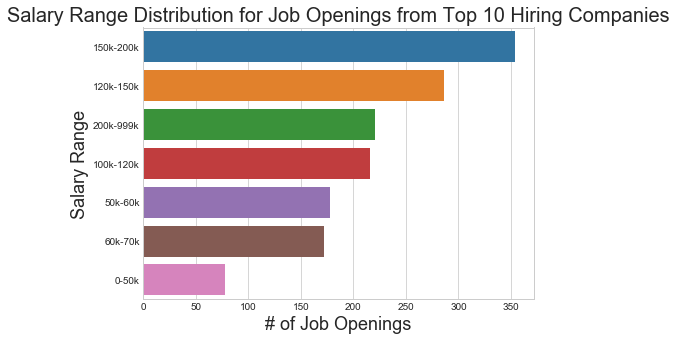

In [18]:
# job openings for top 10 hiring companies
salary_range_count_top_hiring_companies = jobs_df[jobs_df.company.isin(active_hiring_companies_list)].groupby('salary_range').count()['company'].sort_values(ascending=False)
fig = plt.figure(figsize=(7,5))
ax = fig.gca()

sns.barplot(salary_range_count_top_hiring_companies.values,salary_range_count_top_hiring_companies.index, ax=ax)

ax.set_xlabel('# of Job Openings', fontsize=18)
ax.set_ylabel('Salary Range', fontsize=18)
ax.set_title('Salary Range Distribution for Job Openings from Top 10 Hiring Companies', fontsize=20)

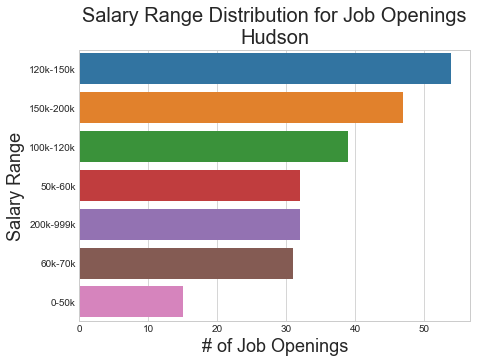

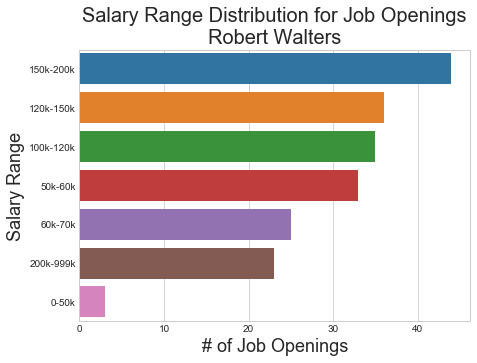

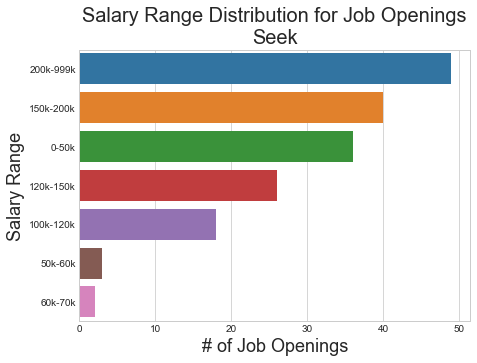

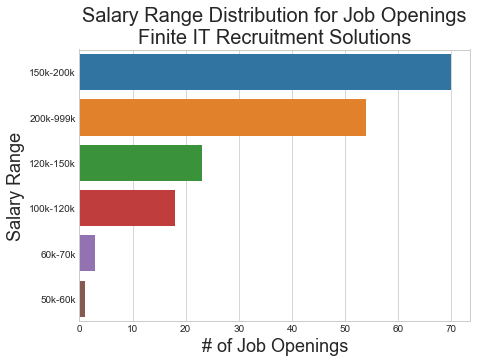

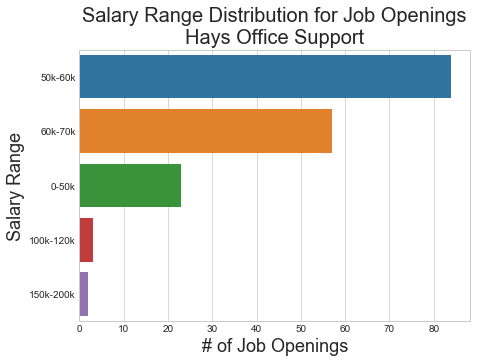

In [19]:
# job openings for each company in top 5 hiring companies
for hiring_company in active_hiring_companies_list[:5]:
    salary_range_count_hiring_company = jobs_df[jobs_df.company==hiring_company].groupby('salary_range').count()['company'].sort_values(ascending=False)
    fig = plt.figure(figsize=(7,5))
    ax = fig.gca()

    sns.barplot(salary_range_count_hiring_company.values,salary_range_count_hiring_company.index, ax=ax)

    ax.set_xlabel('# of Job Openings', fontsize=18)
    ax.set_ylabel('Salary Range', fontsize=18)
    ax.set_title('Salary Range Distribution for Job Openings\n' + hiring_company, fontsize=20)

<a id="top-companies-per-salary-range"></a>

### Top Hiring Companies per Salary Range
[<-](#table-of-contents)

In [31]:
# list the salary range brackets
salary_range_list=list(jobs_df.salary_range.unique())
salary_range_list

['0-50k',
 '50k-60k',
 '60k-70k',
 '100k-120k',
 '120k-150k',
 '150k-200k',
 '200k-999k']

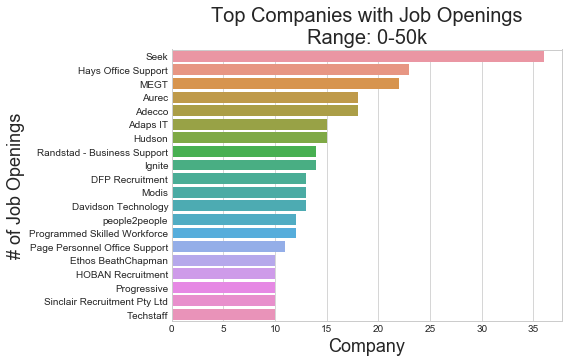

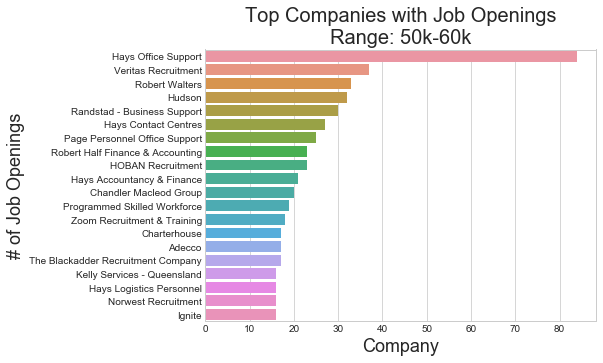

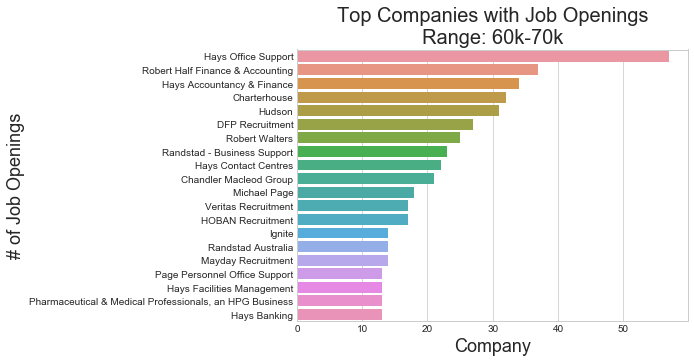

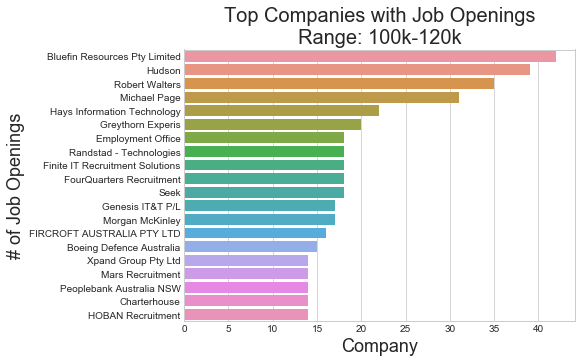

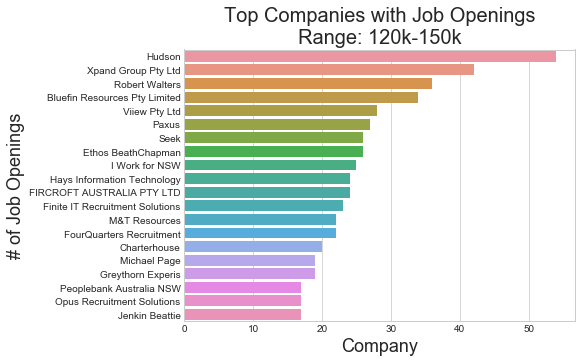

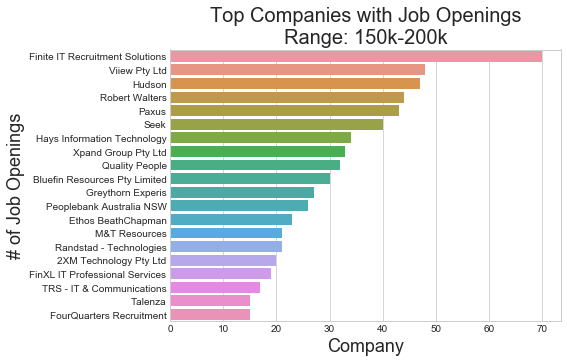

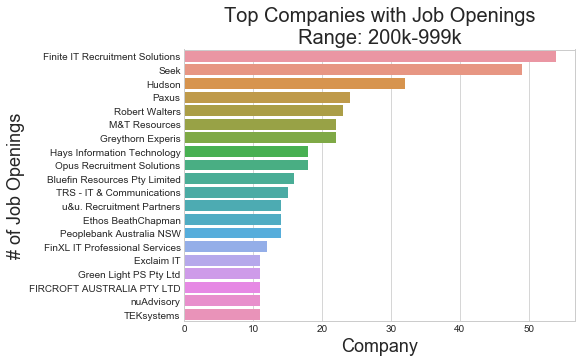

In [21]:
# top hiring companies per salary range
salary_range_list=list(jobs_df.salary_range.unique())

for salary_range in salary_range_list:
    top_hiring_companies_per_salary_range = jobs_df[jobs_df.salary_range==salary_range].groupby('company').count()['date_posted'].sort_values(ascending=False).head(20)
    fig = plt.figure(figsize=(7,5))
    ax = fig.gca()

    sns.barplot(top_hiring_companies_per_salary_range.values,top_hiring_companies_per_salary_range.index, ax=ax)

    ax.set_ylabel('# of Job Openings', fontsize=18)
    ax.set_xlabel('Company', fontsize=18)
    ax.set_title('Top Companies with Job Openings\nRange: ' + salary_range, fontsize=20)


In [32]:
# # save jobs - stage 2.csv for backup
# jobs_df.to_csv('data jobs - stage 2 - after initial EDA.csv')

In [5]:
# # This cell is to be executed ONLY when needing to bypass the scraping AND initial EDA above.
# # In this cell the .csv file containing all the scraped jobs will be loaded to a dataframe
# jobs_df = pd.read_csv('./dataframe backups/data jobs - stage 2 - after initial EDA.csv')

In [3]:
# # drop the sub-index column that was imported from data jobs.csv
# jobs_df.drop(jobs_df.columns[:1],axis=1,inplace=True)

<a id="salary-prediction"></a>

## Salary Classification Prediction
[<-](#table-of-contents)

The main objective here is to predict whether a job's salary is below 70k (classed as Low Salary) or above 100k (classed as high salary). 

The primary features to be considered in making such predictions are job description, job title, and location, while the models to be utilized are Logistic Regression, Naive Bayes, Extra Trees, and Stochastic Gradient Descent, among many others.

- EDA, Feature Selection

In [4]:
# create new dataframe for high vs low salary classification
jobs_highlow = jobs_df.copy()

In [5]:
# set target variable: high salary or low salary
low_salary_ranges = jobs_df.salary_range.unique()[:3]
high_salary_ranges = jobs_df.salary_range.unique()[3:]
jobs_highlow['high_low_salary'] = jobs_df.salary_range.map(lambda x:1 if x in high_salary_ranges else 0)

In [6]:
jobs_highlow.job_type.value_counts()

Full Time        15195
Contract/Temp     5822
Part Time          883
Name: job_type, dtype: int64

In [7]:
# filter jobs to fulltime only
jobs_highlow = jobs_highlow.loc[jobs_highlow.job_type=='Full Time', :]
jobs_highlow.job_type.value_counts()

Full Time    15195
Name: job_type, dtype: int64

In [8]:
jobs_highlow.isnull().sum()

company             5639
date_posted            0
description            0
job_category_1         0
job_category_2         0
job_type               0
location_1             0
location_2          4324
salary             10414
salary_range           0
title                  0
high_low_salary        0
dtype: int64

In [9]:
# filter jobs to 6 major locations : Sydney, Melbourne, Brisbane, Perth, Adelaide, ACT
major_locations = ['Sydney','Melbourne','Brisbane','Perth','Adelaide','ACT']
jobs_highlow = jobs_highlow.loc[jobs_highlow.location_1.isin(major_locations)]

In [10]:
jobs_highlow.location_1.value_counts()

Sydney       6063
Melbourne    3920
Brisbane     1616
Perth         892
Adelaide      490
ACT           351
Name: location_1, dtype: int64

In [11]:
# remove company, salary_range, date_posted, location 2, salary, job_category_1, job_category_2
exclude_columns = ['company','salary_range','date_posted','location_2','salary','job_category_2','job_type']                    
jobs_highlow = jobs_highlow[jobs_highlow.columns[~jobs_highlow.columns.isin(exclude_columns)]]
jobs_highlow.columns

Index(['description', 'job_category_1', 'location_1', 'title',
       'high_low_salary'],
      dtype='object')

In [12]:
# combine 2 dataframes by column, retaining the index of the left dataframe
def append_dataframes_by_column_retain_left_index(df_left, df_right):

    # change right dataframe's index to be the same as the left dataframe
    df_right.set_index(df_left.index,inplace=True)
    # concatenate the 2 dataframes by the columns
    df_left = pd.concat([df_left,df_right],axis=1)

    return df_left

In [13]:
def dummify_columns(df, columns_to_dummify_list):

    # for every column to dummify
    for column in columns_to_dummify_list:

        # fit labelbinarizer to job_category_1 column
        lb = preprocessing.LabelBinarizer(sparse_output=True)
        dummies_sparse = lb.fit_transform(df[column])

        # dummify values to a matrix and load on to a dataframe
        column_names = [(column + '_' + dummy_class) for dummy_class in lb.classes_]
        df_dummies = pd.DataFrame(dummies_sparse.todense(), columns=column_names)
        # drop last column for dummies (to dummify - 1)
        df_dummies.drop(df_dummies.columns[-1], axis=1, inplace=True)
        # drop the original column (the one dummies were based on)
        df.drop(column, axis=1, inplace=True)
        # combine the 2 dataframes, retaining the left dataframe's index
        df = append_dataframes_by_column_retain_left_index(df,df_dummies)
    
    return df

In [ ]:
# dummify job_category_1
columns_to_dummify_list = ['job_category_1']
jobs_highlow = dummify_columns(jobs_highlow,columns_to_dummify_list)

In [ ]:
# dummify location_1
columns_to_dummify_list = ['location_1']
jobs_highlow = dummify_columns(jobs_highlow,columns_to_dummify_list)

In [66]:
# # save jobs - stage 2.csv for backup
# jobs_highlow.to_csv('data jobs - high vs low - after dummify, before train test split.csv')

In [6]:
# # This cell is to be executed ONLY when needing to bypass the scraping AND initial EDA above.
# # In this cell the .csv file containing all the scraped jobs will be loaded to a dataframe
# jobs_highlow = pd.read_csv('./dataframe backups/data jobs - high vs low - after dummify, before train test split.csv')

In [7]:
# # drop the sub-index column that was imported from data jobs.csv
# jobs_highlow.drop(jobs_highlow.columns[:1],axis=1,inplace=True)

### Split dataset into train, dev, test sets

In [14]:
# split to feature, label
exclude_columns = ['high_low_salary']
X = jobs_highlow[jobs_highlow.columns[~jobs_highlow.columns.isin(exclude_columns)]]
y = jobs_highlow.high_low_salary

# split into to train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# split train further into train and dev sets
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# display shapes
print('Full data : ',  X.shape, y.shape)
print('Train set : ', X_train.shape, y_train.shape)
print('Dev set : ',  X_dev.shape, y_dev.shape)
print('Test set : ', X_test.shape, y_test.shape)


Full data :  (13332, 35) (13332,)
Train set :  (8532, 35) (8532,)
Dev set :  (2133, 35) (2133,)
Test set :  (2667, 35) (2667,)


In [15]:
jobs_highlow.dtypes.value_counts()

int64     34
object     2
dtype: int64

### Vectorization of Title column

In [8]:
##### clean data, create corpus, then fit with tfidfvectorizer
def column_to_tfidf_df(values, values_tfidf=None, transform_only=False, porter_stemmer=False, max_features=2500, stop_words_list=None, n_gram_tuple=(2,3)):

    corpus = []
    # clean values
    for value in values:
        # remove html tags
        value = re.sub('(<a href.*>{1})|(<a class.*>{1})|(\\t)|(<[\/]?[a-zA-Z0-9]{0,10}[\/]?>)', ' ', value)
        # limit to letters, exclude every other character
        value = re.sub('[^a-zA-Z]', ' ', value)
        # set to lowercase
        value = value.lower()
        # split then join to fix spacing between words
        value = value.split()
        # apply stemming, if required
        if porter_stemmer:
            # apply stemming with PorterStemmer
            ps = PorterStemmer()
            value = [ps.stem(word) for word in value if word not in stop_words_list]
        value = ' '.join(value)
        # append to corpus the cleaned value
        corpus.append(value)

    # fit and transform (for training set variables)   
    if not(transform_only):
        # initialize TfidfVectorizer with stop_words, tokenize 2-gram and 3-gram
        values_tfidf = TfidfVectorizer(stop_words=stop_words_list, ngram_range=n_gram_tuple, max_features=max_features, max_df=0.80)

        # fit vectorizer to data, transform data, and load vector matrix on to a dataframe
        values_df = pd.DataFrame(values_tfidf.fit_transform(corpus).todense(), columns=values_tfidf.get_feature_names())

    # transform only (for non-training set variables)
    else:
        # transform data using existing fitted model (do not refit model), and load vector matrix on to a dataframe
        values_df = pd.DataFrame(values_tfidf.transform(corpus).todense(), columns=values_tfidf.get_feature_names())
        
        
    return values_tfidf, values_df

In [9]:
def plot_sns_barplot(data, xlabel='_', ylabel='_', title='_'):

    # plot bar chart
    fig = plt.figure(figsize=(10,5))
    ax = fig.gca()
    sns.barplot(data.values,data.index, ax=ax)
    ax.set_xlabel(xlabel, fontsize=18)
    ax.set_ylabel(ylabel, fontsize=19)
    ax.set_title(title, fontsize=20)
    return

In [7]:
# display shapes before vectorization of title column
print('Full data : ',  X.shape, y.shape)
print('Train set : ', X_train.shape, y_train.shape)
print('Dev set : ',  X_dev.shape, y_dev.shape)
print('Test set : ', X_test.shape, y_test.shape)

Full data :  (13332, 35) (13332,)
Train set :  (8532, 35) (8532,)
Dev set :  (2133, 35) (2133,)
Test set :  (2667, 35) (2667,)


In [10]:
# vectorize a column of a dataframe using TfIdf Vectorizer
def vectorize_tfidf(df, col, to_transform_only=False, values_tfidf=None, porter_stemmer=False, max_features=2500, stop_words_list=None, n_gram_tuple=(2,3)):
    
    # Fit Tfidf on the column of the dataframe; return vectorized dataframe and corresponding tfidf object
    tfidf_obj, tfidf_df = column_to_tfidf_df(df[col], values_tfidf, to_transform_only, porter_stemmer, max_features, stop_words_list, n_gram_tuple)
    # combine the 2 dataframes, retaining the left dataframe's index
    tfidf_df = append_dataframes_by_column_retain_left_index(df, tfidf_df)
    # drop the original column
    tfidf_df.drop(col, axis=1, inplace=True)
    
    return tfidf_obj, tfidf_df

In [229]:
# Vectorize X_train's title column
X_train_title_tfidf, X_train = vectorize_tfidf(X_train, 'title', False)
# Vectorize X_dev's title column
X_dev_title_tfidf, X_dev = vectorize_tfidf(X_dev, 'title', True, X_train_title_tfidf)
# Vectorize X_test's title column
X_test_title_tfidf, X_test = vectorize_tfidf(X_test, 'title', True, X_train_title_tfidf)

In [231]:
# display shapes AFTER vectorization of title column
print('Full data : ',  X.shape, y.shape)
print('Train set : ', X_train.shape, y_train.shape)
print('Dev set : ',  X_dev.shape, y_dev.shape)
print('Test set : ', X_test.shape, y_test.shape)

Full data :  (13332, 35) (13332,)
Train set :  (8532, 2534) (8532,)
Dev set :  (2133, 2534) (2133,)
Test set :  (2667, 2534) (2667,)


<a id="top-job-titles"></a>

### Top 20 Job Titles
[<-](#table-of-contents)

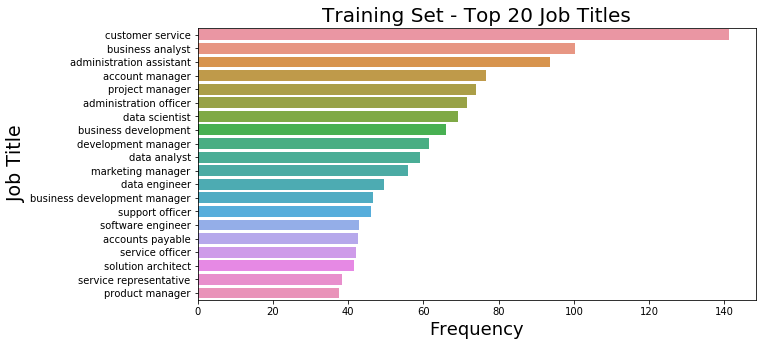

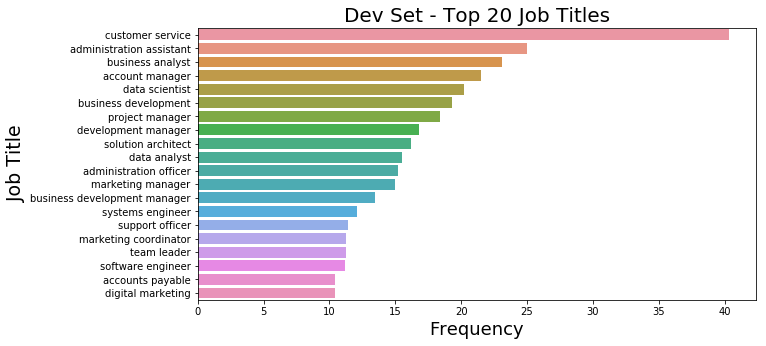

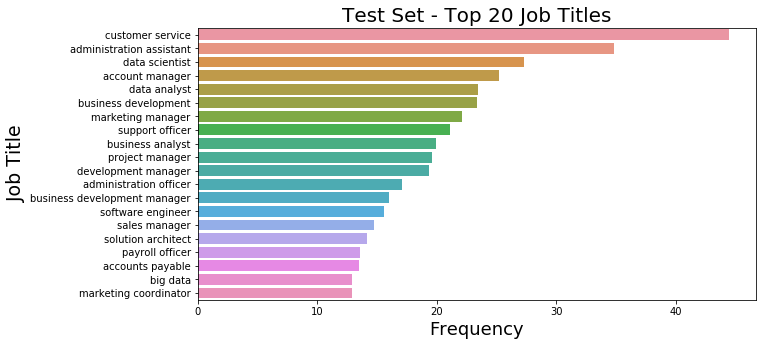

In [80]:
# plot top 20 titles per data subset

# top 20 job titles in training set
title_frequency = X_train_title_df.sum().sort_values(ascending=False).head(20)
plot_sns_barplot(title_frequency,'Frequency','Job Title','Training Set - Top 20 Job Titles')

# top 20 job titles in dev set
title_frequency = X_dev_title_df.sum().sort_values(ascending=False).head(20)
plot_sns_barplot(title_frequency,'Frequency','Job Title','Dev Set - Top 20 Job Titles')

# top 20 job titles in test set
title_frequency = X_test_title_df.sum().sort_values(ascending=False).head(20)
plot_sns_barplot(title_frequency,'Frequency','Job Title','Test Set - Top 20 Job Titles')

In [232]:
# display shapes before vectorization of description column
print('Full data : ',  X.shape, y.shape)
print('Train set : ', X_train.shape, y_train.shape)
print('Dev set : ',  X_dev.shape, y_dev.shape)
print('Test set : ', X_test.shape, y_test.shape)

Full data :  (13332, 35) (13332,)
Train set :  (8532, 2534) (8532,)
Dev set :  (2133, 2534) (2133,)
Test set :  (2667, 2534) (2667,)


In [233]:
# Vectorize X_train's description column
X_train_description_tfidf, X_train = vectorize_tfidf(X_train, 'description', False, None, True)
# Vectorize X_dev's description column
X_dev_description_tfidf, X_dev = vectorize_tfidf(X_dev, 'description', True, X_train_description_tfidf, True)
# Vectorize X_test's description column
X_test_description_tfidf, X_test = vectorize_tfidf(X_test, 'description', True, X_train_description_tfidf, True)

In [234]:
# display shapes AFTER vectorization of description column
print('Full data : ',  X.shape, y.shape)
print('Train set : ', X_train.shape, y_train.shape)
print('Dev set : ',  X_dev.shape, y_dev.shape)
print('Test set : ', X_test.shape, y_test.shape)

Full data :  (13332, 35) (13332,)
Train set :  (8532, 5033) (8532,)
Dev set :  (2133, 5033) (2133,)
Test set :  (2667, 5033) (2667,)


<a id="top-job-descriptions"></a>

### Top 20 Job Descriptions
[<-](#table-of-contents)

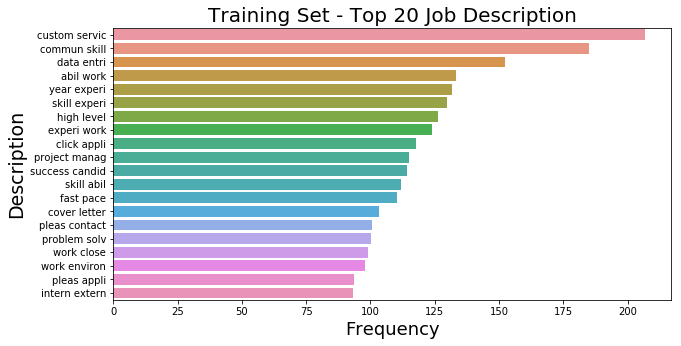

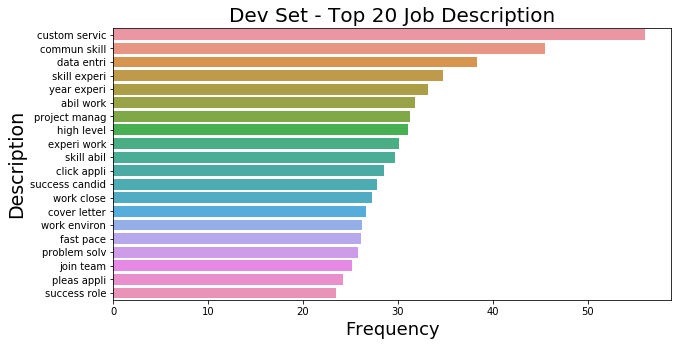

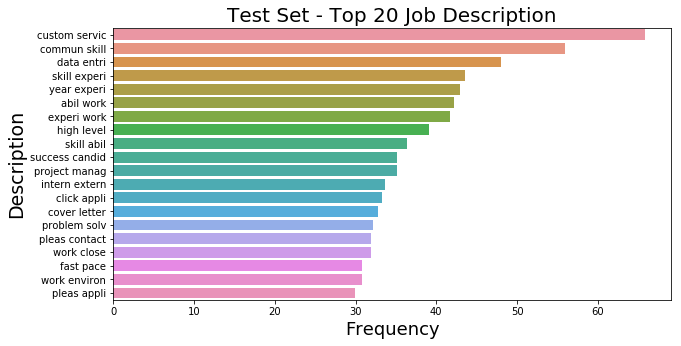

In [87]:
# plot top 20 descriptions per data subset

# top 20 job descriptions in training set
description_frequency = X_train_description_df.sum().sort_values(ascending=False).head(20)
plot_sns_barplot(description_frequency,'Frequency','Description','Training Set - Top 20 Job Description')

# top 20 job descriptions in dev set
description_frequency = X_dev_description_df.sum().sort_values(ascending=False).head(20)
plot_sns_barplot(description_frequency,'Frequency','Description','Dev Set - Top 20 Job Description')

# top 20 job descriptions in test set
description_frequency = X_test_description_df.sum().sort_values(ascending=False).head(20)
plot_sns_barplot(description_frequency,'Frequency','Description','Test Set - Top 20 Job Description')

### Backup train, dev, and test sets as csv and pickle

In [ ]:
def save_to_pickle_csv(df,name,save_as_pkl,save_as_csv):
    
    try:
        rel_path = './dataframe backups/'
        if save_as_pkl:
            df.to_pickle(rel_path + name + '.pkl')
        if save_as_csv:
            df.to_csv(rel_path + name + '.csv')
    except:
        print("Saving as Pickle failed. Check if file with the same name already exists.")

    return

In [89]:
# # export train, dev, test sets to csv and pickle (as backup)
# save_as_pkl=True
# save_as_csv=True
# save_to_pickle_csv(X_train, 'X_train', save_as_pkl, save_as_csv)
# save_to_pickle_csv(X_dev, 'X_dev', save_as_pkl, save_as_csv)
# save_to_pickle_csv(X_test, 'X_test', save_as_pkl, save_as_csv)
# save_to_pickle_csv(y_train, 'y_train', save_as_pkl, save_as_csv)
# save_to_pickle_csv(y_dev, 'y_dev', save_as_pkl, save_as_csv)
# save_to_pickle_csv(y_test, 'y_test', save_as_pkl, save_as_csv)

### Unpickle train, dev, and test sets

In [21]:
def load_from_pickle(name):
    
    try:
        rel_path = './dataframe backups/'
        data = pd.read_pickle(rel_path + name +'.pkl')
    except:
        print('Loading from Pickle failed. File may be missing.')
        
    return data

In [22]:
def load_from_csv(name):
    try:
        rel_path = './dataframe backups/'
        data = pd.read_csv(rel_path + name +'.csv')
    except:
        print('Loading from Pickle failed. File may be missing.')

    return data

In [23]:
# load pickle onto X and y train dev and test sets
X_train = load_from_pickle('X_train')
y_train = load_from_pickle('y_train')
X_dev = load_from_pickle('X_dev')
y_dev = load_from_pickle('y_dev')
X_test = load_from_pickle('X_test')
y_test = load_from_pickle('y_test')

In [24]:
# display shapes AFTER importing from pickle
print('Train set : ', X_train.shape, y_train.shape)
print('Dev set : ',  X_dev.shape, y_dev.shape)
print('Test set : ', X_test.shape, y_test.shape)

Train set :  (8532, 5033) (8532,)
Dev set :  (2133, 5033) (2133,)
Test set :  (2667, 5033) (2667,)


<a id="baseline-accuracy"></a>

### Baseline accuracy
[<-](#table-of-contents)

In [79]:
# baseline classification accuracy

baseline_accuracy = max(y_train.mean(), 1-y_train.mean())
baseline_accuracy

0.543131739334271

<a id="fit-models"></a>

### Fit, Predict, Evaluate Classification Models
[<-](#table-of-contents)

In [16]:
def fit_eval_predict_compare_classification(models, model_names, X_train, y_train, X_test, y_test, cv, positive_class_label, return_fitted_model=False, is_multiclass=False):

    model_summary_list = []
    model_name_list = [] 
    fitted_model_list = []
    roc_auc = '-'
    
    for counter, model in enumerate(models):
        
        # instantiate a Multinomial Naive Bayes model
        mod = model
                
        print('\n\n\nModel: ' + model_names[counter] + '\n')
        
        # evaluate on training set using k-folds cross validation
        cv_scores = cross_val_score(mod, X_train, y_train, cv=cv)
        # mean
        train_cv_scores_mean = cv_scores.mean()
        # standard deviation
        train_cv_scores_std = cv_scores.std()
        print('Cross-val scores (train) : ', cv_scores)

        # train the model
        mod.fit(X_train, y_train)
        
        # evaluate prediction accuracy on test set
        test_accuracy = mod.score(X_test, y_test)

        # evaluate result categories
        # print('true positive: ', sum((y_dev == 1) & (predictions == 1)))
        # print('false positive: ', sum((y_dev == 0) & (predictions == 1)))
        # print('true negative: ', sum((y_dev == 0) & (predictions == 0)))
        # print('false negative: ', sum((y_dev == 1) & (predictions == 0)))

        # generate the confusion matrix in dataframe format
        predictions = mod.predict(X_test)
        
        # Prediction dataframe - save temporarily to csv only for review
        predictions_df = pd.DataFrame([X_test.index, predictions, y_test], index = ['index','prediction','actual']).T
        display('Prediction:')
        display(predictions_df.head(10))                
        
        # Confusion Matrix
        confusion_matrix(y_test, predictions)
        print('\nConfusion Matrix: \n')

        # for multinomial classification
        if is_multiclass:
            confusion_df = pd.DataFrame(confusion_matrix(y_test, predictions)) #, columns = ['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])
        # for binary classification
        else:
            confusion_df = pd.DataFrame(confusion_matrix(y_test, predictions), columns = ['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])
        
        print(confusion_df.head())
        
        # Classification report
        print('\nClassification Report: \n\n' + classification_report(y_test, predictions))
        
        # Recall
        if is_multiclass:
            recall = recall_score(y_test, predictions, average='weighted')
        else:
            recall = recall_score(y_test, predictions)
            
        # Precision
        if is_multiclass:
            precision = precision_score(y_test, predictions, average='weighted')
        else:
            precision = precision_score(y_test, predictions)            
            
        # F1 Score
        f1_score = 2 * ((precision * recall)/(precision + recall))
        
        # AUC-ROC (for binary classification only)
        if not is_multiclass:
            
            # probability matrix
            predict_probabilities = mod.predict_proba(X_test)

            # plot curve
            fpr, tpr, _ = roc_curve(y_test, predict_probabilities[:,1])
            roc_auc = auc(fpr, tpr)
            # Plot of a ROC curve for class 1
            plt.figure(figsize=[7,7])
            plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
            plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
            plt.xlim([-0.05, 1.0])
            plt.ylim([-0.05, 1.05])
            plt.xlabel('False Positive Rate', fontsize=16)
            plt.ylabel('True Positive Rate', fontsize=16)
            plt.title(positive_class_label + ' detection\n' + 'AUC-ROC - ' + model_names[counter], fontsize=16)
            plt.legend(loc="lower right")
            plt.show()
 
        # append model summary to list
        model_summary_list.append([train_cv_scores_mean, train_cv_scores_std, test_accuracy, f1_score, roc_auc])
        model_name_list.append(model_names[counter])
        
        # if return_fitted_model is True, append fitted model
        if return_fitted_model:
            fitted_model_list.append(mod)
     
    column_list = ['CV Score Mean (train)', 'CV Score STD (train)', 'Accuracy (test)', 'F1 Score (test)', 'ROC=AUC (test)']
    model_summary_df = pd.DataFrame(model_summary_list,index=model_name_list,columns=column_list)    
    
    # if fitted model list is to be returned, return it alongside the model_summary_df dataframe
    if return_fitted_model:
        return model_summary_df, fitted_model_list
    
    return model_summary_df

<a id="lr-nb-knn"></a>

### Logistic Regression, Naive Bayes, KNN
[<-](#table-of-contents)




Model: Logistic Regression

Cross-val scores (train) :  [0.91388401 0.93204452 0.90802578 0.92379836 0.90909091]


'Prediction:'

,index,prediction,actual
0,9438,1,0
1,7638,0,0
2,15631,1,1
3,1661,0,0
4,19922,1,1
5,6064,0,0
6,4323,0,0
7,3372,0,0
8,7279,0,0
9,7344,0,0



Confusion Matrix: 

                 Predicted Negative  Predicted Positive
Actual Negative                 859                 116
Actual Positive                  56                1102

Classification Report: 

             precision    recall  f1-score   support

          0       0.94      0.88      0.91       975
          1       0.90      0.95      0.93      1158

avg / total       0.92      0.92      0.92      2133



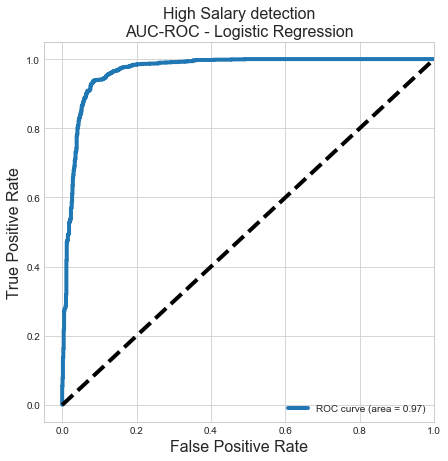




Model: Naive Bayes - Multi

Cross-val scores (train) :  [0.90568248 0.91564148 0.90919742 0.91383353 0.89501466]


'Prediction:'

,index,prediction,actual
0,9438,1,0
1,7638,0,0
2,15631,1,1
3,1661,0,0
4,19922,1,1
5,6064,0,0
6,4323,0,0
7,3372,0,0
8,7279,0,0
9,7344,0,0



Confusion Matrix: 

                 Predicted Negative  Predicted Positive
Actual Negative                 832                 143
Actual Positive                  69                1089

Classification Report: 

             precision    recall  f1-score   support

          0       0.92      0.85      0.89       975
          1       0.88      0.94      0.91      1158

avg / total       0.90      0.90      0.90      2133



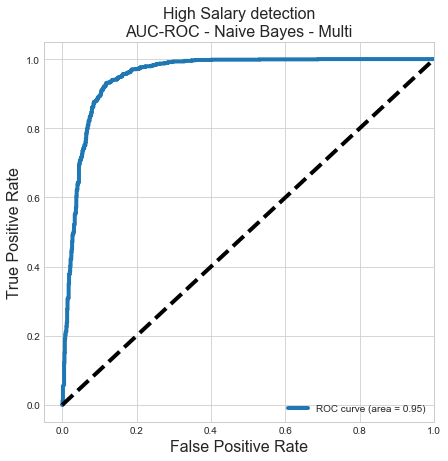




Model: K Nearest Neighbors

Cross-val scores (train) :  [0.847686   0.86115993 0.85998828 0.85111372 0.84046921]


'Prediction:'

,index,prediction,actual
0,9438,1,0
1,7638,0,0
2,15631,1,1
3,1661,0,0
4,19922,0,1
5,6064,0,0
6,4323,0,0
7,3372,0,0
8,7279,0,0
9,7344,0,0



Confusion Matrix: 

                 Predicted Negative  Predicted Positive
Actual Negative                 832                 143
Actual Positive                 152                1006

Classification Report: 

             precision    recall  f1-score   support

          0       0.85      0.85      0.85       975
          1       0.88      0.87      0.87      1158

avg / total       0.86      0.86      0.86      2133



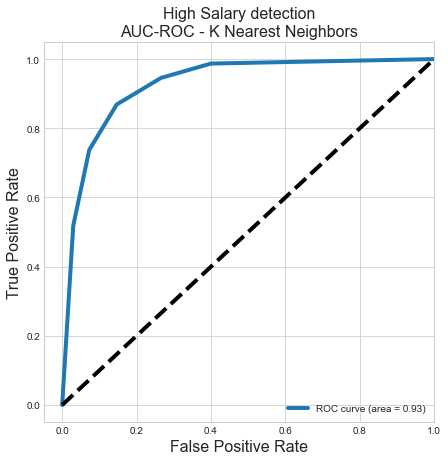

,CV Score Mean (train),CV Score STD (train),Accuracy (test),F1 Score (test),ROC=AUC (test)
Logistic Regression,0.917369,0.009216,0.919362,0.927609,0.968106
Naive Bayes - Multi,0.907874,0.007318,0.900609,0.911297,0.953381
K Nearest Neighbors,0.852083,0.007746,0.861697,0.872128,0.927934


In [271]:
# fit and evaluate the following models:
# 1. Logistic Regression
# 2. Naive Bayes (Multinomial)
# 3. K Nearest Neighbors Classifier

models = [LogisticRegression(),MultinomialNB(),KNeighborsClassifier()]
model_names = ['Logistic Regression','Naive Bayes - Multi','K Nearest Neighbors']
positive_class_label = 'High Salary'
cv=5
model_summary_df = fit_eval_predict_compare_classification(models, model_names, X_train, y_train, X_dev, y_dev, cv, positive_class_label, return_fitted_model=False, is_multiclass=False)
model_summary_df.head(20)

<a id="dt-ensemble"></a>

### Decision Tree, Ensemble models
[<-](#table-of-contents)




Model: Decision Tree

Cross-val scores (train) :  [0.87170475 0.8705331  0.86701816 0.87924971 0.86217009]


'Prediction:'

,index,prediction,actual
0,9438,0,0
1,7638,0,0
2,15631,1,1
3,1661,0,0
4,19922,1,1
5,6064,0,0
6,4323,0,0
7,3372,0,0
8,7279,0,0
9,7344,0,0



Confusion Matrix: 

                 Predicted Negative  Predicted Positive
Actual Negative                 860                 115
Actual Positive                 142                1016

Classification Report: 

             precision    recall  f1-score   support

          0       0.86      0.88      0.87       975
          1       0.90      0.88      0.89      1158

avg / total       0.88      0.88      0.88      2133



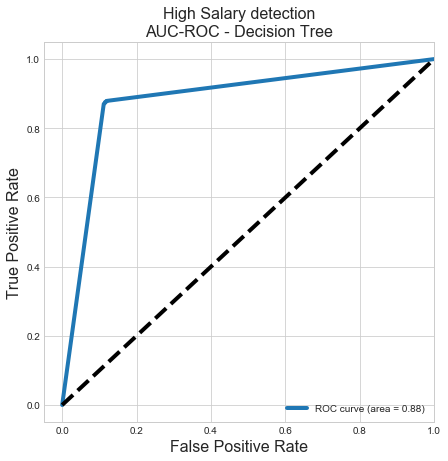




Model: Random Forest

Cross-val scores (train) :  [0.87873462 0.89572349 0.89396602 0.90445487 0.88680352]


'Prediction:'

,index,prediction,actual
0,9438,1,0
1,7638,0,0
2,15631,1,1
3,1661,0,0
4,19922,1,1
5,6064,0,0
6,4323,0,0
7,3372,0,0
8,7279,0,0
9,7344,0,0



Confusion Matrix: 

                 Predicted Negative  Predicted Positive
Actual Negative                 888                  87
Actual Positive                 102                1056

Classification Report: 

             precision    recall  f1-score   support

          0       0.90      0.91      0.90       975
          1       0.92      0.91      0.92      1158

avg / total       0.91      0.91      0.91      2133



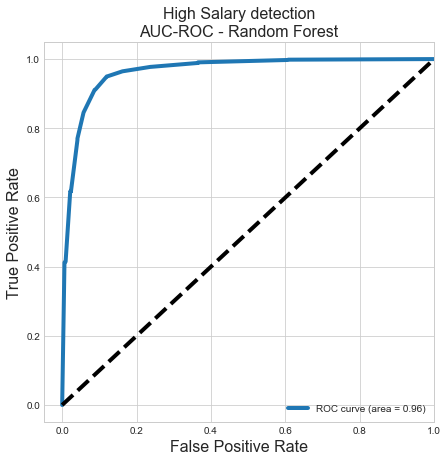




Model: Extra Trees

Cross-val scores (train) :  [0.90802578 0.91505565 0.90509666 0.91735053 0.89560117]


'Prediction:'

,index,prediction,actual
0,9438,1,0
1,7638,0,0
2,15631,1,1
3,1661,0,0
4,19922,1,1
5,6064,0,0
6,4323,0,0
7,3372,0,0
8,7279,0,0
9,7344,0,0



Confusion Matrix: 

                 Predicted Negative  Predicted Positive
Actual Negative                 890                  85
Actual Positive                 100                1058

Classification Report: 

             precision    recall  f1-score   support

          0       0.90      0.91      0.91       975
          1       0.93      0.91      0.92      1158

avg / total       0.91      0.91      0.91      2133



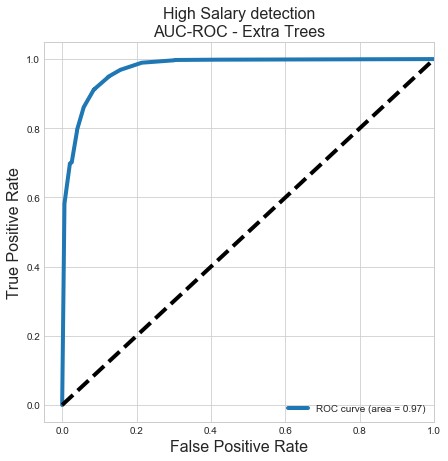




Model: Bagging

Cross-val scores (train) :  [0.89103691 0.89279438 0.89279438 0.89566237 0.88445748]


'Prediction:'

,index,prediction,actual
0,9438,1,0
1,7638,0,0
2,15631,1,1
3,1661,0,0
4,19922,1,1
5,6064,0,0
6,4323,0,0
7,3372,0,0
8,7279,0,0
9,7344,0,0



Confusion Matrix: 

                 Predicted Negative  Predicted Positive
Actual Negative                 874                 101
Actual Positive                 133                1025

Classification Report: 

             precision    recall  f1-score   support

          0       0.87      0.90      0.88       975
          1       0.91      0.89      0.90      1158

avg / total       0.89      0.89      0.89      2133



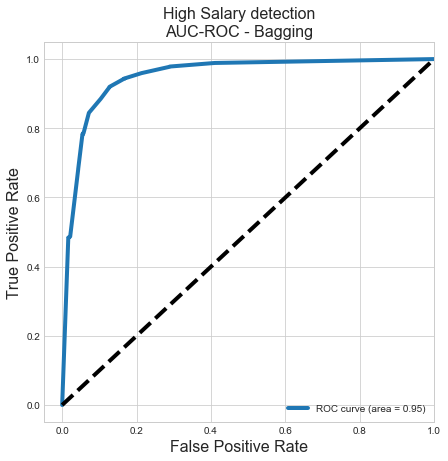

,CV Score Mean (train),CV Score STD (train),Accuracy (test),F1 Score (test),ROC=AUC (test)
Logistic Regression,0.917369,0.009216,0.919362,0.927609,0.968106
Naive Bayes - Multi,0.907874,0.007318,0.900609,0.911297,0.953381
K Nearest Neighbors,0.852083,0.007746,0.861697,0.872128,0.927934
Decision Tree,0.870135,0.005637,0.879512,0.887724,0.882639
Random Forest,0.891937,0.008670,0.911392,0.917862,0.964142
Extra Trees,0.908226,0.007735,0.913268,0.919600,0.972491
Bagging,0.891349,0.003752,0.890295,0.897548,0.950357


In [272]:
# fit and evaluate the following models:
# 1. Decision Tree Classifier
# 2. Random Forest Classifier
# 3. Extra Trees Classifier
# 4. Bagging Classifier

models = [DecisionTreeClassifier(),RandomForestClassifier(),ExtraTreesClassifier(),BaggingClassifier()]
model_names = ['Decision Tree','Random Forest','Extra Trees','Bagging']
positive_class_label = 'High Salary'
cv=5
model_summary_df_2 = fit_eval_predict_compare_classification(models, model_names, X_train, y_train, X_dev, y_dev, cv, positive_class_label, return_fitted_model=False, is_multiclass=False)
model_summary_df = pd.concat([model_summary_df, model_summary_df_2])
model_summary_df.head(20)

<a id="selectkbest"></a>

### Feature Selection - SelectKBest - Logistic Regression
[<-](#table-of-contents)

Use SelectKBest to test different scoring algorithms (f classification, chi-squared, mutual info classification) on the best-performing model (in our case, Logistic Regression). This results to a list of the most important features for use in model construction.

Customize the selection of top features to produce the optimum accuracy score. 

Perform a second run of the best-performing model using the optimum list of features produced by SelectKBest.

In [128]:
# SelectKBest, fit using multiple feature selection algorithms 

# f-classification
skb_fc = SelectKBest(f_classif, k='all')
# chi-squared
skb_ch = SelectKBest(chi2, k='all')
# mutual-info-classification
skb_mc = SelectKBest(mutual_info_classif, k='all')

# fit on data
skb_fc.fit(X_train, y_train)
skb_ch.fit(X_train, y_train)
skb_mc.fit(X_train, y_train)

# load scores onto a dataframe
kbest = pd.DataFrame([X_train.columns, list(skb_fc.scores_), list(skb_ch.scores_), list(skb_mc.scores_)], 
                      index=['feature','f_classification', 'chi_squared', 'mutual_info_classification']).T.sort_values('f_classification', ascending=False)
kbest.head(20)

,feature,f_classification,chi_squared,mutual_info_classification
3099,data entri,2207.44,168.725,0.150219
1,job_category_1_Administration & Office Support,1509.27,1134.29,0.095506
17,job_category_1_Information & Communication Tec...,1289.85,831.452,0.0697967
3071,custom servic,1272.19,153.445,0.0938796
4874,time manag,539.27,44.2846,0.0405015
2952,commun skill,531.765,21.2311,0.0825589
3925,microsoft offic,457.167,42.9936,0.0261575
2611,administr support,423.384,59.7501,0.0337451
3252,duti includ,379.105,44.16,0.0233733
2605,administr duti,378.681,50.832,0.0266498


In [29]:
# Get the optimum number of features, from the ordered list of feature importance through SelectKBest, 
# that yields the highest mean cross-val score; use the model that best performed in the above model performance list
# in this case, Logistic Regression yielded the highest accuracy scores for train and dev sets, as well as the highest F1 score
def SelectKBest_get_best_accuracy (model, kbest_function_list, increment, start_n_features, end_n_features, cv=5):

    # get the top-n best features, through a specified (list of) SelectKBest scoring functions, that yields the best cross-validation metric
    # for logistic regression (best performing model as above)
    top_columns_list=[]
    kbest_result_list = []

    # extract name of model
    model_name = str(model.__class__).split('.')[-1][:-2]

    # iterate through the kbest functions
    for kbest_function in kbest_function_list:
        
        # sort features based on importance/score 
        kbest_current = kbest.sort_values(kbest_function, ascending=False)

        # iterate through the intended feature count to obtain the scores
        for n_features in np.arange(start_n_features, end_n_features, increment):

            if (n_features > 0) & (n_features < len(kbest_current['feature'])):
                # get list of top n features
                top_columns_list = kbest_current['feature'][:n_features]

                # get mean score through selected model and k-folds cv
                mod = model
                mean_score = cross_val_score(mod, X_train[top_columns_list], y_train, cv=5).mean()
                kbest_result_list.append([kbest_function, n_features, mean_score, model_name])

        # plot cross val scores
        fig, ax = plt.subplots(figsize=(15,5))

        num_feature_list = [kbest_result[1] for kbest_result in kbest_result_list]
        mean_score_list = [kbest_result[2] for kbest_result in kbest_result_list]
        sns.pointplot(num_feature_list, mean_score_list, ci=None, ax=ax)
        ax.set_xlabel('N Top Features', fontsize=16)
        ax.set_ylabel('Accuracy', fontsize=16)
        ax.set_title('SelectKBest - ' + kbest_function.capitalize() + '\nCV Scores for N Top Features', fontsize=18)

    # save cross val scores for different kbest functions and # of top features on to a dataframe
    kbest_df = pd.DataFrame(kbest_result_list, columns=['SelectKBest function','# Features','CV Score','Model'])
    display(kbest_df.sort_values('CV Score', ascending=False).head(20))    
    
    return kbest_df.sort_values('CV Score', ascending=False).head(1)

,SelectKBest function,# Features,CV Score,Model
38,chi_squared,4750,0.921237,LogisticRegression
18,f_classification,4750,0.920885,LogisticRegression
15,f_classification,4000,0.919830,LogisticRegression
14,f_classification,3750,0.919713,LogisticRegression
37,chi_squared,4500,0.919713,LogisticRegression
16,f_classification,4250,0.919713,LogisticRegression
17,f_classification,4500,0.919127,LogisticRegression
13,f_classification,3500,0.919010,LogisticRegression
35,chi_squared,4000,0.919010,LogisticRegression
19,f_classification,5000,0.919010,LogisticRegression


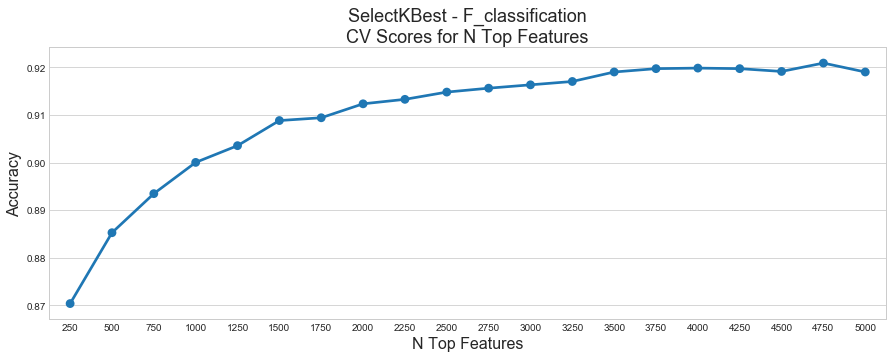

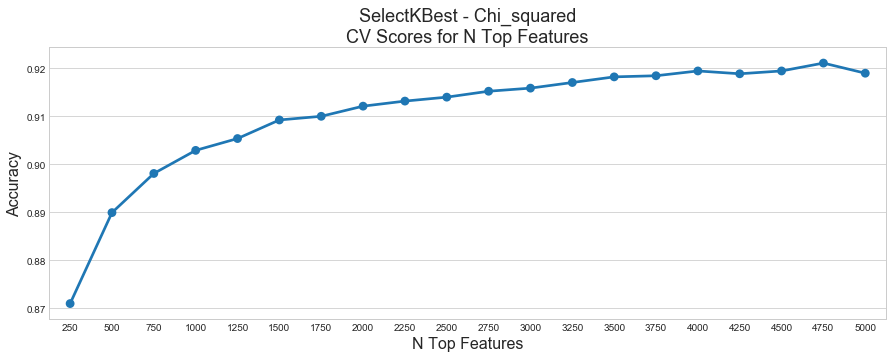

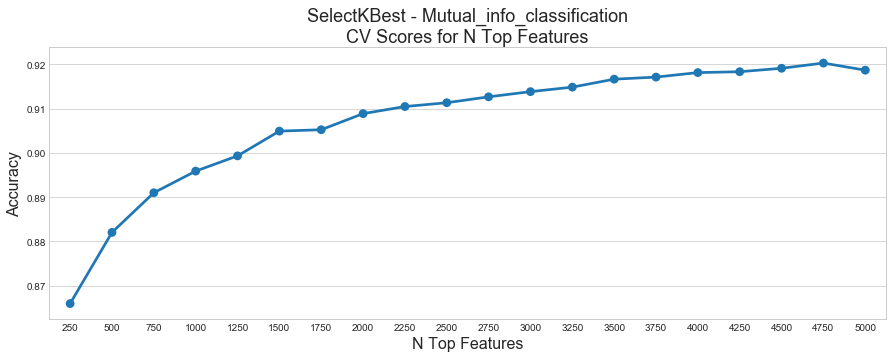

In [239]:
model = LogisticRegression()
kbest_function_list = ['f_classification', 'chi_squared', 'mutual_info_classification']
increment = 250
start_n_features = 0
end_n_features = 5500
cv = 5

kbest_top_result = SelectKBest_get_best_accuracy(model, kbest_function_list, increment, start_n_features, end_n_features, cv)

,SelectKBest function,# Features,CV Score,Model
26,chi_squared,4710,0.921705,LogisticRegression
28,chi_squared,4730,0.921705,LogisticRegression
27,chi_squared,4720,0.921588,LogisticRegression
25,chi_squared,4700,0.921588,LogisticRegression
31,chi_squared,4760,0.921354,LogisticRegression
29,chi_squared,4740,0.921354,LogisticRegression
19,f_classification,4840,0.921354,LogisticRegression
18,f_classification,4830,0.921354,LogisticRegression
30,chi_squared,4750,0.921237,LogisticRegression
24,chi_squared,4690,0.921237,LogisticRegression


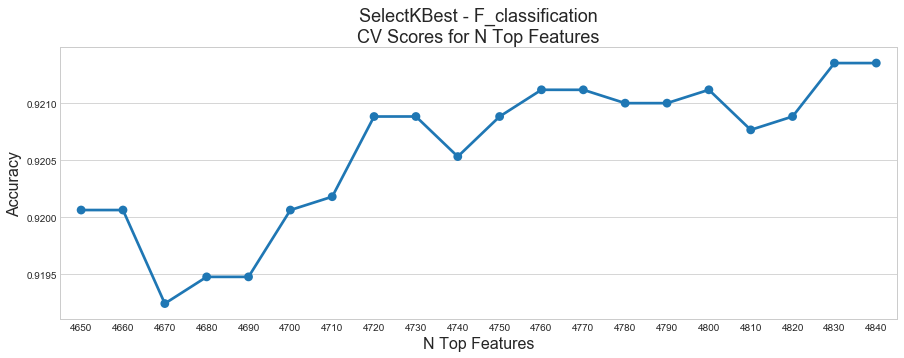

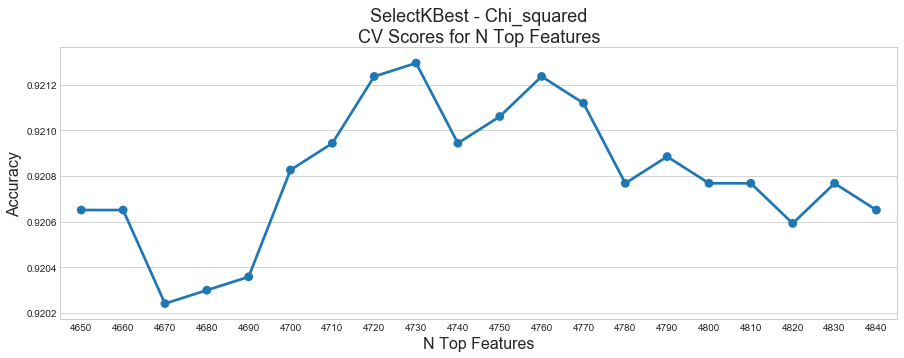

In [240]:
# now, we select the top performing combination of scoring function and # of features
# and zoom in to continue to find the optimum # of features-scoring function pair (to get the highest possible cross validation accuracy score)
model = LogisticRegression()
kbest_function_list = ['f_classification', 'chi_squared']
increment = 10
start_n_features = 4650
end_n_features = 4850
cv = 5

kbest_top_result = SelectKBest_get_best_accuracy(model, kbest_function_list, increment, start_n_features, end_n_features, cv)




model: SelectKBest - Logistic Regression

cross-val scores (train) :  [0.91798477 0.93438781 0.91564148 0.92497069 0.91554252]

Confusion Matrix: 

                 Predicted Negative  Predicted Positive
Actual Negative                 857                 118
Actual Positive                  55                1103

Classification Report: 

             precision    recall  f1-score   support

          0       0.94      0.88      0.91       975
          1       0.90      0.95      0.93      1158

avg / total       0.92      0.92      0.92      2133



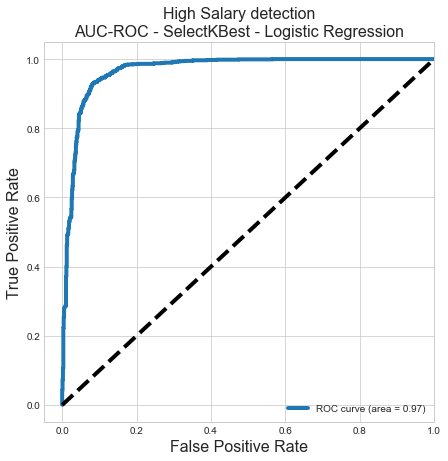

,CV Score Mean (train),CV Score STD (train),Accuracy (test),F1 Score (test),ROC=AUC (test)
Logistic Regression,0.917369,0.009216,0.919362,0.927609,0.968106
Naive Bayes - Multi,0.907874,0.007318,0.900609,0.911297,0.953381
K Nearest Neighbors,0.852083,0.007746,0.861697,0.872128,0.927934
Decision Tree,0.870720,0.007562,0.871542,0.879930,0.874451
Random Forest,0.897093,0.005518,0.913737,0.919510,0.965172
Extra Trees,0.906001,0.002785,0.914205,0.920331,0.972440
Bagging,0.893227,0.005459,0.899672,0.906140,0.956249
SelectKBest - Logistic Regression,0.921705,0.007213,0.918894,0.927280,0.968253


In [130]:
# run best performing model (logistic regression) on the best top-n features
# e.g. best model: Logistic Regression, best function: chi-squared, # of features: 4710

# sort features based on importance/score 
kbest = kbest.sort_values('chi_squared', ascending=False)
top_kbest_features = kbest['feature'][:4710].values

models = [LogisticRegression()]
model_names = ['SelectKBest - Logistic Regression'] 
positive_class_label = 'High Salary'
cv=5
model_summary_df_3 = fit_eval_predict_compare_classification(models, model_names, X_train[top_kbest_features], y_train, X_dev[top_kbest_features], y_dev, cv, positive_class_label, return_fitted_model=False, is_multiclass=False)
#model_summary_df_3.head(20)
model_summary_df = pd.concat([model_summary_df, model_summary_df_3])
model_summary_df.head(20)

<a id="gridsearch-sgd"></a>

###  Stochastic Gradient Descent & GridSearchCV
[<-](#table-of-contents)

In [ ]:
# set up my gridsearch parameters:
sgd_params = {
    'loss':['squared_loss','huber'],
    'penalty':['l1','l2'],
    'alpha':np.logspace(-5,1,25)
}

sgd_clf = SGDClassifier()
sgd_clf_gs = GridSearchCV(sgd_clf, sgd_params, cv=5)
sgd_clf_gs.fit(X_train, y_train);

# get best estimator, best hyperparamaters, best score
grid_sgd_best_params = sgd_clf_gs.best_params_
grid_sgd_best_score = sgd_clf_gs.best_score_
grid_sgd_best_est = sgd_clf_gs.best_estimator_
# evaluate on test set
grid_sgd_test_accuracy = grid_sgd_best_est.score(X_dev, y_dev)

print(grid_sgd_best_params)
print(grid_sgd_best_score)
print(grid_sgd_test_accuracy)

grid_sgd_df = pd.DataFrame([X_train.columns, grid_sgd_best_est.coef_.ravel(), np.abs(grid_sgd_best_est.coef_).ravel()], 
                      index=['feature','coefficient', 'magnitude']).T.sort_values('magnitude', ascending=False);

In [149]:
print('GridSearch SGD Best Params: ',grid_sgd_best_params)

# generate the confusion matrix in dataframe format
predictions = grid_sgd_best_est.predict(X_test)
# metrics.confusion_matrix(y_test, predictions)
print('\nConfusion Matrix: \n')
confusion_df = pd.DataFrame(confusion_matrix(y_test, predictions), columns = ['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])
print(confusion_df.head())

# generate classification report
print('\nClassification Report: \n\n' + classification_report(y_test, predictions))

# generate F1 score
recall = recall_score(y_test, predictions)
precision = precision_score(y_test, predictions)
f1_score = 2 * ((precision * recall)/(precision + recall))

# append model summary to list
model_summary_list = [[grid_sgd_best_score, '-', grid_sgd_test_accuracy, f1_score, '-']]
model_name_list = ['GridSearch - Stochastic GD']

column_list = ['CV Score Mean (train)', 'CV Score STD (train)', 'Accuracy (test)', 'F1 Score (test)', 'ROC=AUC (test)']
grid_summary_df = pd.DataFrame(model_summary_list,index=model_name_list,columns=column_list)    
# grid_summary_df.head()
model_summary_df = pd.concat([model_summary_df, grid_summary_df])
model_summary_df.head(10)

GridSearch SGD Best Params:  {'alpha': 5.623413251903491e-05, 'loss': 'huber', 'penalty': 'l2'}

Confusion Matrix: 

                 Predicted Negative  Predicted Positive
Actual Negative                1056                 162
Actual Positive                  81                1368

Classification Report: 

             precision    recall  f1-score   support

          0       0.93      0.87      0.90      1218
          1       0.89      0.94      0.92      1449

avg / total       0.91      0.91      0.91      2667



C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



,Accuracy (test),CV Score Mean (train),CV Score STD (train),F1 Score (test),ROC=AUC (test)
Logistic Regression,0.919362,0.917369,0.00921602,0.927609,0.968106
Naive Bayes - Multi,0.900609,0.907874,0.00731801,0.911297,0.953381
K Nearest Neighbors,0.861697,0.852083,0.00774645,0.872128,0.927934
Decision Tree,0.871542,0.870720,0.00756164,0.879930,0.874451
Random Forest,0.913737,0.897093,0.00551766,0.919510,0.965172
Extra Trees,0.914205,0.906001,0.00278537,0.920331,0.97244
Bagging,0.899672,0.893227,0.00545944,0.906140,0.956249
SelectKBest - Logistic Regression,0.918894,0.921705,0.0072125,0.927280,0.968253
GridSearch - Stochastic GD,0.911861,0.910338,-,0.918429,-


<a id="model-performance-comparison-chart"></a>

### Model Performance Comparison - Chart
[<-](#table-of-contents)

In [156]:
# rename columns (test to dev)
model_summary_df.rename(columns={'Accuracy (test)':'Accuracy (dev)', 'F1 Score (test)':'F1 Score (dev)', 'ROC=AUC (test)':'ROC=AUC (dev)'}, inplace=True)
model_summary_df.sort_values('Accuracy (dev)', ascending=False).head(10)

,CV Score Mean (train),CV Score STD (train),Accuracy (dev),F1 Score (dev),ROC=AUC (dev)
Logistic Regression,0.917369,0.00921602,0.919362,0.927609,0.968106
SelectKBest - Logistic Regression,0.921705,0.0072125,0.918894,0.927280,0.968253
Extra Trees,0.906001,0.00278537,0.914205,0.920331,0.97244
Random Forest,0.897093,0.00551766,0.913737,0.919510,0.965172
GridSearch - Stochastic GD,0.910338,-,0.911861,0.918429,-
Naive Bayes - Multi,0.907874,0.00731801,0.900609,0.911297,0.953381
Bagging,0.893227,0.00545944,0.899672,0.906140,0.956249
Decision Tree,0.870720,0.00756164,0.871542,0.879930,0.874451
K Nearest Neighbors,0.852083,0.00774645,0.861697,0.872128,0.927934


<a id="model-performance-comparison-conclusion"></a>

### Model Performance Comparison - Conclusion
[<-](#table-of-contents)

Based on the above chart, Logistic Regression proves to be the best performing model for this dataset, with a very consistent score obtained for both the train and dev sets, 91.74% and 91.94% respectively. This model similarly yielded the best F1 Score (92.76%).

Although SelectKBest - Logistic Regression had a slightly better cross val score for the train set (92.17%) than Logistic Regression, it may have overfitted a little bit due to the lesser accuracy score it obtained for the dev set (91.89%). 

## ---------------------------------------------------------------------------

<a id="fit-model-test-set"></a>

### Fit Final Model on Test Set:
[<-](#table-of-contents)

Fit best-performing model on the combined Train and Dev sets, then evaluate against the (unseen) Test Set

In [25]:
# display shapes BEFORE combining train and dev sets
print('Train set : ', X_train.shape, y_train.shape)
print('Dev set : ',  X_dev.shape, y_dev.shape)
print('Test set : ', X_test.shape, y_test.shape)

Train set :  (8532, 5033) (8532,)
Dev set :  (2133, 5033) (2133,)
Test set :  (2667, 5033) (2667,)


In [26]:
# concatenate the train and dev sets for both the predictors and the labels
# this is to prepare the set for final model fitting (using the combined train-dev set) and performance evaluation (using hte unseen test set)
X_train_dev = pd.concat([X_train,X_dev])
y_train_dev = pd.concat([y_train,y_dev])

In [27]:
# display shapes AFTER combining train and dev sets
print('Combined Train-Dev set : ', X_train_dev.shape, y_train_dev.shape)
print('Test set : ', X_test.shape, y_test.shape)

Combined Train-Dev set :  (10665, 5033) (10665,)
Test set :  (2667, 5033) (2667,)





Model: Logistic Regression

Cross-val scores (train) :  [0.92877226 0.92221181 0.93061416 0.91651032 0.92026266]


'Prediction:'

,index,prediction,actual
0,8781,0,0
1,20451,1,1
2,2401,0,0
3,11065,1,1
4,13034,1,1
5,18864,1,1
6,14001,1,1
7,6365,0,0
8,21815,1,1
9,9234,0,0



Confusion Matrix: 

                 Predicted Negative  Predicted Positive
Actual Negative                1085                 133
Actual Positive                  70                1379

Classification Report: 

             precision    recall  f1-score   support

          0       0.94      0.89      0.91      1218
          1       0.91      0.95      0.93      1449

avg / total       0.92      0.92      0.92      2667



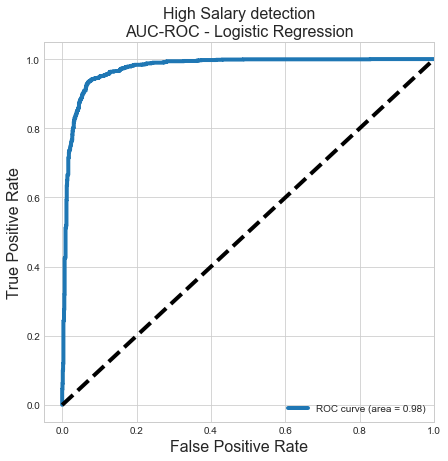

,feature,coef,abs
3099,data entri,-5.03311,5.03311
3071,custom servic,-3.98989,3.98989
22,"job_category_1_Mining, Resources & Energy",2.98106,2.98106
2611,administr support,-2.43298,2.43298
1,job_category_1_Administration & Office Support,-2.38252,2.38252
4874,time manag,-2.37365,2.37365
3252,duti includ,-2.36921,2.36921
4666,stakehold manag,2.26846,2.26846
2428,technical officer,-2.25539,2.25539
2764,best practic,2.24667,2.24667


,CV Score Mean (train),CV Score STD (train),Accuracy (test),F1 Score (test),ROC=AUC (test)
Logistic Regression,0.923674,0.005277,0.923885,0.931442,0.975036


In [28]:
# fit and evaluate best-performing model on the train-dev set and the final (unseen) test set, respectively
models = [LogisticRegression()]
model_names = ['Logistic Regression'] 
positive_class_label = 'High Salary'
cv=5
model_summary_df_final, fitted_model_list = fit_eval_predict_compare_classification(models, model_names, X_train_dev, y_train_dev, X_test, y_test, cv, positive_class_label, return_fitted_model=True, is_multiclass=False)

# display the coefficients for the fitted model in a dataframe
coef_df = pd.DataFrame([X_train_dev.columns, fitted_model_list[0].coef_[0,:], np.abs(fitted_model_list[0].coef_[0,:])], index=['feature','coef','abs']).T
display(coef_df.sort_values('abs', ascending=False).head(20))

# display model summary
model_summary_df_final.head(4)

<a id="fit-model-test-set-conclusion"></a>

### Fit Final Model on Test Set - Conclusion
[<-](#table-of-contents)

The best-performing model, Logistic Regression, was this time fitted on the combined train and dev sets, then evaluated against the unseen Test set.

The final results, as per chart, are as follows:
Cross-Validation Accuracy Score on Train-Dev Set: 92.37%
Accuracy Score on (unseen) Test Set: 92.39%
F1 Score: 93.14%

## ----------------------------------------------------------------


<a id="minimize-wrong-predictions"></a>

### Minimize Wrong Predictions of High Salary
[<-](#table-of-contents)

- Adjust threshold so that prediction of a high salary will only occur when the probability of such occurrence is no less than 90%
- This is especially applicable in scenarios where wrongly equating a job to high salary has to be avoided at all cost.

In [31]:
X_test_proba_df = pd.DataFrame(np.round(fitted_model_list[0].predict_proba(X_test)*100,2), columns=['low_salary', 'high_salary'])
X_test_proba_df['adjusted_high_low_salary'] = X_test_proba_df.high_salary.apply(lambda x: 1 if x > 90 else 0)
print('Adjusted High/Low Salary Predictions:')
X_test_proba_df.set_index(X_test.index).head(10)

Adjusted High/Low Salary Predictions:


,low_salary,high_salary,adjusted_high_low_salary
8781,95.40,4.60,0
20451,5.24,94.76,1
2401,75.59,24.41,0
11065,1.27,98.73,1
13034,5.40,94.60,1
18864,3.52,96.48,1
14001,10.72,89.28,0
6365,94.42,5.58,0
21815,11.41,88.59,0
9234,77.67,22.33,0


In [468]:
# plot the Confusion Matrix on to a dataframe
confusion_matrix(y_test, X_test_proba_df.adjusted_high_low_salary)
confusion_df = pd.DataFrame(confusion_matrix(y_test, X_test_proba_df.adjusted_high_low_salary), columns = ['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])
confusion_df.head()

,Predicted Negative,Predicted Positive
Actual Negative,1204,14
Actual Positive,601,848


<a id="minimize-wrong-predictions-conclusion"></a>

### Minimize Wrong Predictions of High Salary - Conclusion
[<-](#table-of-contents)

- After adjusting the probability threshold of High Salary predictions to 90%, the false positive count for the test set has gone down to 14, from the original value of 133, as per original and adjusted confusion matrices, respectively. 
- In other words, we are able to correctly predict high salary jobs with 90% (or higher) probability, thereby minimizing the potential costs involved in misdeclaring a job as such.

## ----------------------------------------------------------


<a id="job-role-prediction"></a>

### Job Role Prediction
[<-](#table-of-contents)

In this section, we aim to do the following:
1. predict the job role based solely on the job description
2. identify the top features contained in the job description that distinguish each job role

Job roles to be predicted are the following:
1. data scientist
2. data engineer
3. data analyst
4. data - other

item # 4 is for all jobs that do not belong to the first three, but has the term 'data' in the job title

For instance, the job role 'data engineer' can have 'big data' as its top feature. What this means is that under the job description the term 'big data' is effectively present across the 'data engineer' jobs and thereby playing a crucial role in identifying that it is, indeed, a 'data engineer' job.

In [471]:
# get indices of jobs that fall under each 'job title bucket'
data_scientist_indices = [index for index, title in jobs_highlow.title.iteritems() if "data scientist" in title.lower()]
data_engineer_indices = [index for index, title in jobs_highlow.title.iteritems() if "data engineer" in title.lower()]
data_analyst_indices = [index for index, title in jobs_highlow.title.iteritems() if "data analyst" in title.lower()]

# other data roles - roles with 'data' in title, excluding the specific data roles identified above
data_main_roles_indices = data_scientist_indices + data_engineer_indices + data_analyst_indices
data_other_indices = [index for index, title in jobs_highlow.title.iteritems() if ("data" in title.lower()) & (index not in data_main_roles_indices)]

# add up all data role indices into 1 list
all_data_roles_indices = data_scientist_indices + data_engineer_indices + data_analyst_indices + data_other_indices
#all_data_roles_indices = data_scientist_indices + data_engineer_indices + data_analyst_indices

In [472]:
# trim dataset to rows (jobs) with the term 'data' in the job title, and columns (features) that are relevant 
# this will be the main dataset to use for this job classification section
jobs_highlow_jc = jobs_highlow.loc[all_data_roles_indices,['description','role']]

In [473]:
# set the new label 'role' to the values with corresponding job title, as follows:
jobs_highlow_jc.loc[data_scientist_indices,'role'] = 0
jobs_highlow_jc.loc[data_engineer_indices,'role'] = 1
jobs_highlow_jc.loc[data_analyst_indices,'role'] = 2
jobs_highlow_jc.loc[data_other_indices,'role'] = 3

In [474]:
# set predictors and label variables
X_jc = jobs_highlow_jc[['description']]
y_jc = jobs_highlow_jc['role']

# split into to train and test sets
X_train_jc, X_test_jc, y_train_jc, y_test_jc = train_test_split(X_jc, y_jc, test_size=0.2, random_state=42, stratify=y_jc)

# display shapes
print('Full data : ',  X_jc.shape, y_jc.shape)
print('Train set : ', X_train_jc.shape, y_train_jc.shape)
print('Test set : ', X_test_jc.shape, y_test_jc.shape)

Full data :  (1110, 1) (1110,)
Train set :  (888, 1) (888,)
Test set :  (222, 1) (222,)


In [475]:
# add new stop words to nltk's English stopwords
# these new stop words are applicable for the job classification prediction
stopwords_jc = stopwords.words('english')
new_stopwords = ['life', 'diversity', 'inclusion', 'confidential', 'balance', 'key', 'melbourne', 'queensland', 'nsw', 'cbd', 'blank', 'href', 'looking', 'cover', 'letter', 'state', 'new', 'existing', 'join', 'full', 'part', 'time', 'team', 'working', 'least', 'provide', 'experienced', 'position', 'click', 'please', 'call', 'ad', 'hoc', 'gov', 'au', 'also']
#new_stopwords = ['life', 'diversity', 'inclusion', 'scientist', 'engineer', 'analyst', 'scientists', 'engineers', 'analysts', 'science', 'confidential', 'discussion', 'please', 'nsw', 'university', 'perform', 'technologies', 'excellent', 'platform', 'identify', 'statistical', 'software', 'improve', 'skills', 'work', 'balance', 'key', 'melbourne', 'cbd', 'looking', 'high', 'cover', 'letter', 'state', 'new', 'existing', 'join', 'full', 'part', 'time', 'team', 'working', 'least', 'provide']
stopwords_jc.extend(new_stopwords)

# Vectorize X_train's and X_test's description column
X_train_jc_description_tfidf, X_train_jc = vectorize_tfidf(X_train_jc, 'description', False, None, False, 400, stopwords_jc, n_gram_tuple=(2,2))
X_test_jc_description_tfidf, X_test_jc = vectorize_tfidf(X_test_jc, 'description', True, X_train_jc_description_tfidf, False, 400, stopwords_jc, n_gram_tuple=(2,2))

In [476]:
# get indices of jobs in the training set that fall under each 'job title bucket'
data_scientist_indices_jc = [index for index, value in y_train_jc.iteritems() if value == 0]
data_engineer_indices_jc = [index for index, value in y_train_jc.iteritems() if value == 1]
data_analyst_indices_jc = [index for index, value in y_train_jc.iteritems() if value == 2]
data_other_indices_jc = [index for index, value in y_train_jc.iteritems() if value == 3]

In [477]:
# identify minority job class
minority_class_row_count = np.min([len(data_scientist_indices_jc), len(data_engineer_indices_jc)
                                   , len(data_analyst_indices_jc), len(data_other_indices_jc)])
#minority_class_row_count = np.min([len(data_scientist_indices_jc), len(data_engineer_indices_jc), len(data_analyst_indices_jc)])

# downsample the other job classes to the # of jobs of the minority job class
data_scientist_indices_jc_dwn = np.random.choice(data_scientist_indices_jc, minority_class_row_count, replace=True)
data_analyst_indices_jc_dwn = np.random.choice(data_analyst_indices_jc, minority_class_row_count, replace=True)
data_other_indices_jc_dwn = np.random.choice(data_other_indices_jc, minority_class_row_count, replace=True)
(minority_class_row_count, len(data_scientist_indices_jc_dwn), len(data_analyst_indices_jc_dwn)
 , len(data_engineer_indices_jc), len(data_other_indices_jc_dwn))
#minority_class_row_count, len(data_scientist_indices_jc_dwn), len(data_analyst_indices_jc_dwn), len(data_engineer_indices_jc)

(92, 92, 92, 92, 92)

In [478]:
# update training set to only include the downsampled data
X_train_jc = X_train_jc.loc[list(data_engineer_indices_jc) + list(data_scientist_indices_jc_dwn) + list(data_analyst_indices_jc_dwn) + list(data_other_indices_jc_dwn), :]
y_train_jc = y_train_jc.loc[list(data_engineer_indices_jc) + list(data_scientist_indices_jc_dwn) + list(data_analyst_indices_jc_dwn) + list(data_other_indices_jc_dwn)]
#X_train_jc = X_train_jc.loc[list(data_engineer_indices_jc) + list(data_scientist_indices_jc_dwn) + list(data_analyst_indices_jc_dwn) , :]
#y_train_jc = y_train_jc.loc[list(data_engineer_indices_jc) + list(data_scientist_indices_jc_dwn) + list(data_analyst_indices_jc_dwn)]

In [483]:
# fit and evaluate the following models:
# 1. Logistic Regression
# 2. Naive Bayes (Multinomial)
# 3. K Nearest Neighbors
# 4. Decision Tree
# 5. Random Forest
# 6. Extra Trees
# 7. Bagging

# models = [LogisticRegression()]
# model_names = ['Logistic Regression']
models = [LogisticRegression(),MultinomialNB(),KNeighborsClassifier(),DecisionTreeClassifier(),RandomForestClassifier(),ExtraTreesClassifier(),BaggingClassifier()]
model_names = ['Logistic Regression','Naive Bayes - Multi','K Nearest Neighbors','Decision Tree','Random Forest','Extra Trees','Bagging']
positive_class_label = '-'
cv=5
model_summary_df, fitted_model_list = fit_eval_predict_compare_classification(models, model_names, X_train_jc, y_train_jc
                                                            , X_test_jc, y_test_jc, cv, positive_class_label
                                                            , return_fitted_model=True, is_multiclass=True)
model_summary_df.sort_values('Accuracy (test)', ascending=False).head(10)




Model: Logistic Regression

Cross-val scores (train) :  [0.88157895 0.86842105 0.91780822 0.93150685 0.875     ]


'Prediction:'

,index,prediction,actual
0,9247.0,0.0,3.0
1,6274.0,1.0,1.0
2,9117.0,3.0,3.0
3,2576.0,3.0,3.0
4,1391.0,2.0,3.0
5,1396.0,3.0,3.0
6,11738.0,0.0,0.0
7,6188.0,2.0,3.0
8,9152.0,3.0,3.0
9,6116.0,3.0,3.0



Confusion Matrix: 

    0   1   2    3
0  27   0   3    2
1   1  22   0    0
2   0   0  22    4
3   9   9  11  112

Classification Report: 

             precision    recall  f1-score   support

        0.0       0.73      0.84      0.78        32
        1.0       0.71      0.96      0.81        23
        2.0       0.61      0.85      0.71        26
        3.0       0.95      0.79      0.86       141

avg / total       0.85      0.82      0.83       222




Model: Naive Bayes - Multi

Cross-val scores (train) :  [0.84210526 0.85526316 0.87671233 0.8630137  0.84722222]


'Prediction:'

,index,prediction,actual
0,9247.0,0.0,3.0
1,6274.0,1.0,1.0
2,9117.0,3.0,3.0
3,2576.0,3.0,3.0
4,1391.0,2.0,3.0
5,1396.0,3.0,3.0
6,11738.0,0.0,0.0
7,6188.0,2.0,3.0
8,9152.0,3.0,3.0
9,6116.0,3.0,3.0



Confusion Matrix: 

    0   1   2   3
0  29   0   3   0
1   1  22   0   0
2   0   0  22   4
3  11  21  27  82

Classification Report: 

             precision    recall  f1-score   support

        0.0       0.71      0.91      0.79        32
        1.0       0.51      0.96      0.67        23
        2.0       0.42      0.85      0.56        26
        3.0       0.95      0.58      0.72       141

avg / total       0.81      0.70      0.71       222




Model: K Nearest Neighbors

Cross-val scores (train) :  [0.81578947 0.81578947 0.79452055 0.76712329 0.79166667]


'Prediction:'

,index,prediction,actual
0,9247.0,0.0,3.0
1,6274.0,1.0,1.0
2,9117.0,0.0,3.0
3,2576.0,3.0,3.0
4,1391.0,2.0,3.0
5,1396.0,3.0,3.0
6,11738.0,0.0,0.0
7,6188.0,0.0,3.0
8,9152.0,2.0,3.0
9,6116.0,1.0,3.0



Confusion Matrix: 

    0   1   2   3
0  27   1   3   1
1   2  20   1   0
2   4   1  16   5
3  22  29  28  62

Classification Report: 

             precision    recall  f1-score   support

        0.0       0.49      0.84      0.62        32
        1.0       0.39      0.87      0.54        23
        2.0       0.33      0.62      0.43        26
        3.0       0.91      0.44      0.59       141

avg / total       0.73      0.56      0.57       222




Model: Decision Tree

Cross-val scores (train) :  [0.84210526 0.90789474 0.93150685 0.93150685 0.88888889]


'Prediction:'

,index,prediction,actual
0,9247.0,0.0,3.0
1,6274.0,1.0,1.0
2,9117.0,3.0,3.0
3,2576.0,3.0,3.0
4,1391.0,3.0,3.0
5,1396.0,3.0,3.0
6,11738.0,0.0,0.0
7,6188.0,3.0,3.0
8,9152.0,3.0,3.0
9,6116.0,3.0,3.0



Confusion Matrix: 

    0   1   2    3
0  24   0   2    6
1   0  21   0    2
2   0   0  23    3
3  10   6  14  111

Classification Report: 

             precision    recall  f1-score   support

        0.0       0.71      0.75      0.73        32
        1.0       0.78      0.91      0.84        23
        2.0       0.59      0.88      0.71        26
        3.0       0.91      0.79      0.84       141

avg / total       0.83      0.81      0.81       222




Model: Random Forest

Cross-val scores (train) :  [0.85526316 0.88157895 0.95890411 0.89041096 0.84722222]


'Prediction:'

,index,prediction,actual
0,9247.0,0.0,3.0
1,6274.0,1.0,1.0
2,9117.0,3.0,3.0
3,2576.0,3.0,3.0
4,1391.0,3.0,3.0
5,1396.0,3.0,3.0
6,11738.0,0.0,0.0
7,6188.0,2.0,3.0
8,9152.0,3.0,3.0
9,6116.0,3.0,3.0



Confusion Matrix: 

    0   1   2    3
0  29   0   2    1
1   0  22   0    1
2   0   0  24    2
3   9  12   7  113

Classification Report: 

             precision    recall  f1-score   support

        0.0       0.76      0.91      0.83        32
        1.0       0.65      0.96      0.77        23
        2.0       0.73      0.92      0.81        26
        3.0       0.97      0.80      0.88       141

avg / total       0.88      0.85      0.85       222




Model: Extra Trees

Cross-val scores (train) :  [0.85526316 0.89473684 0.91780822 0.95890411 0.84722222]


'Prediction:'

,index,prediction,actual
0,9247.0,0.0,3.0
1,6274.0,1.0,1.0
2,9117.0,3.0,3.0
3,2576.0,3.0,3.0
4,1391.0,2.0,3.0
5,1396.0,3.0,3.0
6,11738.0,0.0,0.0
7,6188.0,2.0,3.0
8,9152.0,3.0,3.0
9,6116.0,3.0,3.0



Confusion Matrix: 

    0   1   2    3
0  29   0   1    2
1   1  21   0    1
2   0   0  22    4
3  13  10  10  108

Classification Report: 

             precision    recall  f1-score   support

        0.0       0.67      0.91      0.77        32
        1.0       0.68      0.91      0.78        23
        2.0       0.67      0.85      0.75        26
        3.0       0.94      0.77      0.84       141

avg / total       0.84      0.81      0.82       222




Model: Bagging

Cross-val scores (train) :  [0.86842105 0.94736842 0.95890411 0.94520548 0.86111111]


'Prediction:'

,index,prediction,actual
0,9247.0,0.0,3.0
1,6274.0,1.0,1.0
2,9117.0,3.0,3.0
3,2576.0,3.0,3.0
4,1391.0,3.0,3.0
5,1396.0,3.0,3.0
6,11738.0,0.0,0.0
7,6188.0,3.0,3.0
8,9152.0,3.0,3.0
9,6116.0,3.0,3.0



Confusion Matrix: 

    0   1   2    3
0  26   0   2    4
1   0  21   0    2
2   0   0  23    3
3  10   6   6  119

Classification Report: 

             precision    recall  f1-score   support

        0.0       0.72      0.81      0.76        32
        1.0       0.78      0.91      0.84        23
        2.0       0.74      0.88      0.81        26
        3.0       0.93      0.84      0.88       141

avg / total       0.86      0.85      0.85       222



,CV Score Mean (train),CV Score STD (train),Accuracy (test),F1 Score (test),ROC=AUC (test)
Bagging,0.916202,0.042318,0.851351,0.856670,-
Random Forest,0.886676,0.039497,0.846847,0.861003,-
Logistic Regression,0.894863,0.025058,0.824324,0.838477,-
Extra Trees,0.894787,0.041147,0.810811,0.826087,-
Decision Tree,0.900381,0.033233,0.806306,0.817626,-
Naive Bayes - Multi,0.856863,0.012208,0.698198,0.750000,-
K Nearest Neighbors,0.796978,0.018074,0.563063,0.635575,-


In [525]:
# display the prediction probabilities for every job in the test set
# eg. 'job with index 9247 has 90% probability to be a data scientist role and 10% as a data analyst role.'
# use the fitted Random Forest model - model seems to output whole number percentages which provides clear separation between classes
X_test_proba_df = pd.DataFrame(np.round(fitted_model_list[4].predict_proba(X_test_jc)*100, 2), columns=['Data Scientist', 'Data Engineer', 'Data Analyst', 'Data - Other'])
X_test_proba_df.set_index(X_test_jc.index).head()

,Data Scientist,Data Engineer,Data Analyst,Data - Other
9247,90.0,0.0,10.0,0.0
6274,0.0,100.0,0.0,0.0
9117,0.0,0.0,10.0,90.0
2576,0.0,10.0,10.0,80.0
1391,10.0,0.0,40.0,50.0


<a id="feature-identification"></a>

### Identification of Important Features
[<-](#table-of-contents)

Important features are key details within a job advertisement that help identify the job role as either that of a data scientist, data engineer, or a data analyst.

In [504]:
# for each label (in this case, job role), display the coefficients in order of importance
# use the fitted Logistic Regression model to segregate the coefficients per class
class_labels = ['Data Scientist', 'Data Engineer', 'Data Analyst', 'Data - Other']
for target_class in range(0,len(fitted_model_list[0].classes_)):
    coef_df = pd.DataFrame([X_train_jc.columns, fitted_model_list[0].coef_[target_class,:]
                            , np.abs(fitted_model_list[0].coef_[target_class,:])], index=['feature','coef','abs']).T
    print('\n\nJob Role: ', class_labels[target_class])
    display(coef_df.sort_values('abs', ascending=False).head(10))



Job Role:  Data Scientist


,feature,coef,abs
125,data science,3.69504,3.69504
126,data scientist,3.39053,3.39053
252,machine learning,2.5593,2.5593
102,data engineer,-1.33087,1.33087
92,data analyst,-1.30516,1.30516
259,mathematics statistics,0.965782,0.965782
298,python experience,0.921343,0.921343
183,experience python,0.878167,0.878167
293,programming skills,0.82542,0.82542
391,work home,0.821426,0.821426




Job Role:  Data Engineer


,feature,coef,abs
102,data engineer,4.14052,4.14052
47,big data,3.17946,3.17946
103,data engineering,1.78673,1.78673
92,data analyst,-1.49465,1.49465
126,data scientist,-1.35265,1.35265
127,data scientists,1.34129,1.34129
125,data science,-1.30497,1.30497
104,data engineers,1.21058,1.21058
118,data pipeline,1.18474,1.18474
34,asset management,1.14374,1.14374




Job Role:  Data Analyst


,feature,coef,abs
92,data analyst,4.25494,4.25494
91,data analysis,2.57899,2.57899
47,big data,-1.69311,1.69311
102,data engineer,-1.44996,1.44996
125,data science,-1.42659,1.42659
252,machine learning,-1.39032,1.39032
31,arq group,1.17076,1.17076
126,data scientist,-1.0388,1.0388
236,internal stakeholders,0.995932,0.995932
192,external stakeholders,0.893828,0.893828




Job Role:  Data - Other


,feature,coef,abs
92,data analyst,-2.11339,2.11339
102,data engineer,-1.91587,1.91587
47,big data,-1.80603,1.80603
91,data analysis,-1.75979,1.75979
125,data science,-1.71522,1.71522
96,data centre,1.59246,1.59246
126,data scientist,-1.30435,1.30435
341,sql server,1.30375,1.30375
252,machine learning,-1.24569,1.24569
128,data sets,-1.2271,1.2271


<a id="job-role-prediction-conclusion"></a>

## Job Role Prediction - Conclusion
[<-](#table-of-contents)

Bagging Classifier has proven to be the best performing model with an 85.13% accuracy score on the (unseen) test set.

We were also able to provide the top 10 features for each job role. For data engineer, 2 notable features identified are 'data pipeline' and 'big data'. For data scientist, they are 'machine learning' and 'mathematics statistics'.

Setting the following parameters yielded the highest and most consistent accuracy scores on the test set:
- n-gram range: (2,2)
- max_df: 1.0
- max_features = 400
- porterstemmer = False

When setting the n-gram range to (1,1) and (1,2) and customizing the stopwords accordingly, notable features that made a lot of sense appeared. For instance, the features 'aws' and 'cloud' appeared in the top 10 list for the data engineer role. 

However, these n-gram range settings didn't perform as well, consistently getting a lower accuracy score in the 73-77% range. 

## -----------------------------------------------------------------